# 03 Tuning  
This notebook housed my first attempts to combine the separately explored numerical and categorical features from notebooks 1 and 2.  

### Skip ahead:
[Model 1](#Model-1)  
[Model 2](#Model-2)  
[Model 3](#Model-3) (First categorical features)  
[Model 4](#Model-4)  
[Model 5](#Model-5)  
[Model 6](#Model-6)  
[Model 7](#Model-7)  
[Model 8](#Model-8) (Polynomial transformation)  
[Model 9](#Model-9) (Log transformation)  
[Model 10](#Model-10)  
[Model 11](#Model-11)  
[Model 12](#Model-12)  
[Model 13](#Model-13)  
[Model 14](#Model-14)  
[Model 15](#Model-15)  
[Model 16](#Model-16) (Enter the .PY file)  
[To Production!](#To-Production!) (Epilogue)

In [102]:
from scipy.stats import ttest_ind
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures


In [103]:
home = pd.read_csv('../datasets/train.csv')

In order to make sorting / calling / organizing easier, I'm going to make all columns lowercase and remove spaces.

In [104]:
home.columns = [col.lower().replace(' ', '_') for col in home.columns]

In [105]:
home.head(1)

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500


Okay, that looks good!

## Model 1

This first model is the same as the first model in my numerical notebook.

Time to make a 'features' list with these elements. This will be the basis for my very first competition entry:

In [106]:
features = ['overall_qual', 'year_built', 'year_remod/add', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area']

I wrote this function to full train a model based on a few simple inputs:

In [107]:
#accepts df name, test_name, features list, any feature columns that need to be dummified
def make_model(df, test_name, features, dum_cols):
    X = df[features].fillna(0) #will make nan (should only be numerical) values zeroes
    if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, otherwise enter '0'
        X = pd.get_dummies(X, columns=dum_cols, drop_first=True)
    y = df['saleprice'] #add target
    lr = LinearRegression()
    lr.fit(X, y)
    lr.score(X, y)
    pred = lr.predict(X)
    return f'Your RMSE for test {test_name} is {metrics.mean_squared_error(y, pred)**.5}.'

In [108]:
make_model(home, 'numerical', features, 0)

'Your RMSE for test numerical is 36384.774108824015.'

There we go! Our first training model provides an RMSE of 36384.77 which is at least a start. I used this model for my first kaggle submission - that work was done originally in my "num_filters" notebook.

I wrote this function to create a new csv submission for any models that have good training scores:

In [109]:
def save_test(df, test_name, features_list, dum_cols):
    X = df[features_list].fillna(0) #will make nan (should only be numerical) values zeroes
    if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, otherwise enter '0'
        X = pd.get_dummies(X, columns=dum_cols, drop_first=True)
    y = df['saleprice'] #add target
    lr = LinearRegression()
    lr.fit(X, y)
    test = pd.read_csv('datasets/test.csv') #read in test file
    test.columns = [col.lower().replace(' ', '_') for col in test.columns] #reformat test columns
    sub = test[['id']].copy() #put id numbers in empty array
    X_test = test[features].fillna(0) #create X value based on selected features, fill (numerical) nans with 0's
    if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, else enter '0'
        
        pd.get_dummies(X_test, columns=dum_cols, drop_first=True)
    sub['SalePrice'] = lr.predict(X_test) #make new df column from predictions
    sub = sub.rename(columns = {'id' : 'Id'}) #rename id column to fit submission model
    sub['Id'] = [int(n) for n in sub['Id']] #make id numbers ints to fit submission model
    sub.to_csv(f'models/mod{test_name}.csv', index=False) #save submission as new csv
    return f"All done, submission {test_name} saved"

## Model 2

I'm curious about some of the features that didn't make my top 10 but could still be valuable in my model - I'm going to add some of them and see how it affects my RMSE:  
- mas_vnr_area  
- totrms_abvgrd  
- fireplaces

In [110]:
features = ['overall_qual', 'year_built', 'year_remod/add', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces']

In [111]:
make_model(home, 'numerical', features, 0)

'Your RMSE for test numerical is 35356.18459383637.'

Oho! That brought my RMSE down about 1000! I'm going to go ahead and submit this model to the leaderboard, see if it does any better with the test data.

In [112]:
#save_test(home, 'plus3num', features, 0)

Cool! I uploaded this one and went up one rank on the leaderboard. Progress!

## Model 3
This is where I first introduced categorical features.

In [113]:
home2 = home.copy()

In [114]:
home2['ms_cat'] = 'other' #making a new column for zone categories
home2.loc[(home2['ms_zoning'] == 'I (all)') | 
      (home2['ms_zoning'] == 'A (agr)') | 
      (home2['ms_zoning'] == 'C (all)'),
     'ms_cat']='ms1' #zone1 includes I, A, C types
home2.loc[home2['ms_zoning'] == 'RH', 'ms_cat']='ms2'
home2.loc[home2['ms_zoning'] == 'FV', 'ms_cat']='ms3'
home2.loc[home2['ms_zoning'] == 'RM', 'ms_cat']='ms4'

In [115]:
home2['n_cat'] = 'other' #making a new column for neighborhood category- if there is anything my filters don't catch, they'll roll into "other"

home2.loc[(home2['neighborhood'] == 'MeadowV') | (home2['neighborhood'] == 'IDOTRR'), 'n_cat']='zone1'

home2.loc[(home2['neighborhood'] == 'BRDale') | (home2['neighborhood'] == 'OldTown'), 'n_cat']='zone2'

home2.loc[(home2['neighborhood'] == 'Edwards') | (home2['neighborhood'] == 'BrkSide') | (home2['neighborhood'] == 'Sawyer'), 'n_cat']='zone3'

home2.loc[(home2['neighborhood'] == 'SWISU') | (home2['neighborhood'] == 'Landmrk') | (home2['neighborhood'] == 'Blueste'), 'n_cat']='zone4'

home2.loc[(home2['neighborhood'] == 'NAmes') | (home2['neighborhood'] == 'NPKVill'), 'n_cat']='zone5'

home2.loc[home2['neighborhood'] == 'Mitchell', 'n_cat']='zone6'

home2.loc[(home2['neighborhood'] == 'Gilbert') | (home2['neighborhood'] == 'SawyerW') | (home2['neighborhood'] == 'NWAmes'), 'n_cat']='zone7'

#home2.loc[(home2['neighborhood'] == 'Greens') | (home2['neighborhood'] == 'Blmngtn') | (home2['neighborhood'] == 'CollgCr'), 'n_cat']='zone8' 
#I'm going to let this just be "other"; it's going to be a large category so if we happen to have any odd neighborhoods not listed, they wont change this too much

home2.loc[(home2['neighborhood'] == 'Timber') | (home2['neighborhood'] == 'Somerst'), 'n_cat']='zone9'

home2.loc[home2['neighborhood'] == 'ClearCr', 'n_cat']='zone10'

home2.loc[(home2['neighborhood'] == 'Veenker') | (home2['neighborhood'] == 'GrnHill'), 'n_cat']='zone11'

home2.loc[home2['neighborhood'] == 'NoRidge', 'n_cat']='zone12'

home2.loc[home2['neighborhood'] == 'NridgeHt', 'n_cat']='zone13'

home2.loc[home2['neighborhood'] == 'StoneBr', 'n_cat']='zone14'

In [116]:
home2['h_cat'] = 'other'

home2.loc[home2['heating'] == 'GasA', 'h_cat']='GasA'

home2.loc[home2['heating'] == 'GasW', 'h_cat']='GasW'

#the other 3 categories will stay together as "other"

In [117]:
home2['k_cat'] = 'other'

home2.loc[home2['kitchen_qual'] == 'TA', 'k_cat']='TA'

home2.loc[home2['kitchen_qual'] == 'Gd', 'k_cat']='Gd'

home2.loc[home2['kitchen_qual'] == 'Ex', 'k_cat']='Ex'

#Fair + any poors in the test set will stay as 'other'

home2['k_cat'].value_counts()

TA       1047
Gd        806
Ex        151
other      47
Name: k_cat, dtype: int64

In [118]:
home2['st_cat'] = 'other'

home2.loc[home2['sale_type'] == 'New', 'st_cat']='New'

home2.loc[(home2['sale_type'] == 'Oth') | (home2['sale_type'] == 'ConLI') | (home2['sale_type'] == 'ConLw'), 'st_cat']='occ'

home2.loc[(home2['sale_type'] == 'CWD') | (home2['sale_type'] == 'Con'), 'st_cat']='cwn'

home2.loc[(home2['sale_type'] == 'COD') | (home2['sale_type'] == 'ConLD'), 'st_cat']='cld'

#WD plus any other unrepresented categories (like VWD) will fall into "other"

In [119]:
cat_features = ['ms_cat', 'n_cat', 'bldg_type', 'h_cat', 'central_air', 'k_cat', 'st_cat']
features = ['overall_qual', 'year_built', 'year_remod/add', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces']
all_feat = cat_features + features
all_feat

['ms_cat',
 'n_cat',
 'bldg_type',
 'h_cat',
 'central_air',
 'k_cat',
 'st_cat',
 'overall_qual',
 'year_built',
 'year_remod/add',
 'total_bsmt_sf',
 'gr_liv_area',
 'full_bath',
 'garage_area',
 'mas_vnr_area',
 'totrms_abvgrd',
 'fireplaces']

In [120]:
make_model(home2, 'cat_and_num', all_feat, cat_features)

'Your RMSE for test cat_and_num is 30487.9119879809.'

Okay, that's the best score I've gotten so far! Let's run the test data through and make another submission on Kaggle. I need to add the making of new columns and grouping of column categories into my function so that it will apply itself to the test data.

In [121]:
def save_test(df, test_name, features_list, dum_cols):
    X = df[features_list].fillna(0) #will make nan (should only be numerical) values zeroes
    #if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, otherwise enter '0'
    X = pd.get_dummies(X, columns=dum_cols, drop_first=True)
    y = df['saleprice'] #add target
    lr = LinearRegression()
    lr.fit(X, y)
    #print('first done')
    test = pd.read_csv('datasets/test.csv') #read in test file
    test.columns = [col.lower().replace(' ', '_') for col in test.columns] #reformat test columns
    sub = test[['id']].copy() #put id numbers in empty array
    
    #apply categorical column grouping changes to test data
    home2 = test.copy()
    
    home2['ms_cat'] = 'other' #making a new column for zone categories
    home2.loc[(home2['ms_zoning'] == 'I (all)') | 
          (home2['ms_zoning'] == 'A (agr)') | 
          (home2['ms_zoning'] == 'C (all)'),
         'ms_cat']='zone1' #zone1 includes I, A, C types
    home2.loc[home2['ms_zoning'] == 'RH', 'ms_cat']='zone2'
    home2.loc[home2['ms_zoning'] == 'FV', 'ms_cat']='zone3'
    home2.loc[home2['ms_zoning'] == 'RM', 'ms_cat']='zone4'
    
    home2['n_cat'] = 'other' #making a new column for neighborhood category- if there is anything my filters don't catch, they'll roll into "other"
    home2.loc[(home2['neighborhood'] == 'MeadowV') | (home2['neighborhood'] == 'IDOTRR'), 'n_cat']='zone1'
    home2.loc[(home2['neighborhood'] == 'BRDale') | (home2['neighborhood'] == 'OldTown'), 'n_cat']='zone2'
    home2.loc[(home2['neighborhood'] == 'Edwards') | (home2['neighborhood'] == 'BrkSide') | (home2['neighborhood'] == 'Sawyer'), 'n_cat']='zone3'
    home2.loc[(home2['neighborhood'] == 'SWISU') | (home2['neighborhood'] == 'Landmrk') | (home2['neighborhood'] == 'Blueste'), 'n_cat']='zone4'
    home2.loc[(home2['neighborhood'] == 'NAmes') | (home2['neighborhood'] == 'NPKVill'), 'n_cat']='zone5'
    home2.loc[home2['neighborhood'] == 'Mitchell', 'n_cat']='zone6'
    home2.loc[(home2['neighborhood'] == 'Gilbert') | (home2['neighborhood'] == 'SawyerW') | (home2['neighborhood'] == 'NWAmes'), 'n_cat']='zone7'
    home2.loc[(home2['neighborhood'] == 'Timber') | (home2['neighborhood'] == 'Somerst'), 'n_cat']='zone9'
    home2.loc[home2['neighborhood'] == 'ClearCr', 'n_cat']='zone10'
    home2.loc[(home2['neighborhood'] == 'Veenker') | (home2['neighborhood'] == 'GrnHill'), 'n_cat']='zone11'
    home2.loc[home2['neighborhood'] == 'NoRidge', 'n_cat']='zone12'
    home2.loc[home2['neighborhood'] == 'NridgeHt', 'n_cat']='zone13'
    home2.loc[home2['neighborhood'] == 'StoneBr', 'n_cat']='zone14'

    home2['h_cat'] = 'other' #new column for heating categories
    home2.loc[home2['heating'] == 'GasA', 'h_cat']='GasA'
    home2.loc[home2['heating'] == 'GasW', 'h_cat']='GasW'
    
    home2['k_cat'] = 'other' #new column for kitchen qual categories
    home2.loc[home2['kitchen_qual'] == 'TA', 'k_cat']='TA'
    home2.loc[home2['kitchen_qual'] == 'Gd', 'k_cat']='Gd'
    home2.loc[home2['kitchen_qual'] == 'Ex', 'k_cat']='Ex'
    
    home2['st_cat'] = 'other' #new column for sale type categories
    home2.loc[home2['sale_type'] == 'New', 'st_cat']='New'
    home2.loc[(home2['sale_type'] == 'Oth') | (home2['sale_type'] == 'ConLI') | (home2['sale_type'] == 'ConLw'), 'st_cat']='occ'
    home2.loc[(home2['sale_type'] == 'CWD') | (home2['sale_type'] == 'Con'), 'st_cat']='cwn'
    home2.loc[(home2['sale_type'] == 'COD') | (home2['sale_type'] == 'ConLD'), 'st_cat']='cld' 
    
    test = home2.copy()
    #print('cats done')
    #sub = test[['id']].copy() #put id numbers in empty array
    X_test = test[features_list].fillna(0) #create X value based on selected features, fill (numerical) nans with 0's
    #if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, else enter '0'
    X_test = pd.get_dummies(X_test, columns=dum_cols, drop_first=True)
    #return X_test.dtypes
    sub['SalePrice'] = lr.predict(X_test) #make new df column from predictions
    #print('sub done')
    sub = sub.rename(columns = {'id' : 'Id'}) #rename id column to fit submission model
    sub['Id'] = [int(n) for n in sub['Id']] #make id numbers ints to fit submission model
    sub.to_csv(f'models/mod{test_name}.csv', index=False) #save submission as new csv
    return f"All done, submission {test_name} saved"

In [122]:
#save_test(home2, 'cat_and_num1', all_feat, cat_features)

Alright, that took about $4k off my prior submission, progress!

## Model 4

I want to see where I'm missing on my model - is there an obvious overshoot or under-prediction going on? I'm going to try to modify my make_model function to also give me a residual graph when it provides the RMSE.

In [123]:
#got help from lesson 3.06 notes

In [124]:
#accepts df name, test_name, features list, any feature columns that need to be dummified
def make_model(df, test_name, features, dum_cols):
    X = df[features].fillna(0) #will make nan (should only be numerical) values zeroes
    if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, otherwise enter '0'
        X = pd.get_dummies(X, columns=dum_cols, drop_first=True)
    y = df['saleprice'] #add target
    lr = LinearRegression()
    lr.fit(X, y)
    print(f'Your R2 score is {lr.score(X, y)}')
    pred = lr.predict(X)
    residuals = y - pred #these are the residuals
    residuals.hist()
    plt.axvline(0, color = 'red')
    plt.show()
    return f'Your RMSE for test {test_name} is {metrics.mean_squared_error(y, pred)**.5}.'

In [125]:
home2 = home.copy()
home2['ms_cat'] = 'other' #making a new column for zone categories
home2.loc[(home2['ms_zoning'] == 'I (all)') | 
      (home2['ms_zoning'] == 'A (agr)') | 
      (home2['ms_zoning'] == 'C (all)'),
     'ms_cat']='zone1' #zone1 includes I, A, C types
home2.loc[home2['ms_zoning'] == 'RH', 'ms_cat']='zone2'
home2.loc[home2['ms_zoning'] == 'FV', 'ms_cat']='zone3'
home2.loc[home2['ms_zoning'] == 'RM', 'ms_cat']='zone4'

home2['n_cat'] = 8 #making a new column for neighborhood category- if there is anything my filters don't catch, they'll roll into "other"
home2.loc[(home2['neighborhood'] == 'MeadowV') | (home2['neighborhood'] == 'IDOTRR'), 'n_cat']=1
home2.loc[(home2['neighborhood'] == 'BRDale') | (home2['neighborhood'] == 'OldTown'), 'n_cat']=2
home2.loc[(home2['neighborhood'] == 'Edwards') | (home2['neighborhood'] == 'BrkSide') | (home2['neighborhood'] == 'Sawyer'), 'n_cat']=3
home2.loc[(home2['neighborhood'] == 'SWISU') | (home2['neighborhood'] == 'Landmrk') | (home2['neighborhood'] == 'Blueste'), 'n_cat']=4
home2.loc[(home2['neighborhood'] == 'NAmes') | (home2['neighborhood'] == 'NPKVill'), 'n_cat']=5
home2.loc[home2['neighborhood'] == 'Mitchell', 'n_cat']=6
home2.loc[(home2['neighborhood'] == 'Gilbert') | (home2['neighborhood'] == 'SawyerW') | (home2['neighborhood'] == 'NWAmes'), 'n_cat']=7
home2.loc[(home2['neighborhood'] == 'Timber') | (home2['neighborhood'] == 'Somerst'), 'n_cat']=9
home2.loc[home2['neighborhood'] == 'ClearCr', 'n_cat']=10
home2.loc[(home2['neighborhood'] == 'Veenker') | (home2['neighborhood'] == 'GrnHill'), 'n_cat']=11
home2.loc[home2['neighborhood'] == 'NoRidge', 'n_cat']=12
home2.loc[home2['neighborhood'] == 'NridgeHt', 'n_cat']=13
home2.loc[home2['neighborhood'] == 'StoneBr', 'n_cat']=14

home2['h_cat'] = 'other' #new column for heating categories
home2.loc[home2['heating'] == 'GasA', 'h_cat']='GasA'
home2.loc[home2['heating'] == 'GasW', 'h_cat']='GasW'

home2['k_cat'] = 'other' #new column for kitchen qual categories
home2.loc[home2['kitchen_qual'] == 'TA', 'k_cat']='TA'
home2.loc[home2['kitchen_qual'] == 'Gd', 'k_cat']='Gd'
home2.loc[home2['kitchen_qual'] == 'Ex', 'k_cat']='Ex'

home2['st_cat'] = 'other' #new column for sale type categories
home2.loc[home2['sale_type'] == 'New', 'st_cat']='New'
home2.loc[(home2['sale_type'] == 'Oth') | (home2['sale_type'] == 'ConLI') | (home2['sale_type'] == 'ConLw'), 'st_cat']='occ'
home2.loc[(home2['sale_type'] == 'CWD') | (home2['sale_type'] == 'Con'), 'st_cat']='cwn'
home2.loc[(home2['sale_type'] == 'COD') | (home2['sale_type'] == 'ConLD'), 'st_cat']='cld' 

home2.head()

,id,pid,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,...,misc_val,mo_sold,yr_sold,sale_type,saleprice,ms_cat,n_cat,h_cat,k_cat,st_cat
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,3,2010,WD,130500,other,3,GasA,Gd,other
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,4,2009,WD,220000,other,7,GasA,Gd,other
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,1,2010,WD,109000,other,5,GasA,Gd,other
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,4,2010,WD,174000,other,9,GasA,TA,other
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,3,2010,WD,138500,other,7,GasA,TA,other


In [126]:
cat_features = ['ms_cat', 'n_cat', 'bldg_type', 'h_cat', 'central_air', 'k_cat', 'st_cat']
features = ['overall_qual', 'year_built', 'year_remod/add', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces']
all_feat = cat_features + features

Your R2 score is 0.8519618260830043


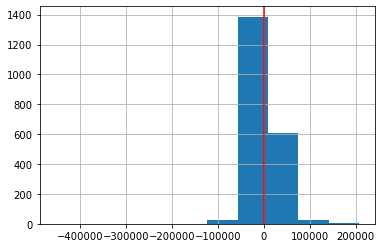

'Your RMSE for test cat_and_num2 is 30487.91198798089.'

In [127]:
make_model(home2, 'cat_and_num2', all_feat, cat_features)

The high bar below zero suggests that y - y_pred is often negative, meaning my prediction is larger than y i.e. an over-shoot. Perhaps I can fix this with a simple modification.

## Model 5

In [128]:
#accepts df name, test_name, features list, any feature columns that need to be dummified
def make_model(df, test_name, features, dum_cols):
    X = df[features].fillna(0) #will make nan (should only be numerical) values zeroes
    if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, otherwise enter '0'
        X = pd.get_dummies(X, columns=dum_cols, drop_first=True)
    y = df['saleprice'] #add target
    lr = LinearRegression()
    lr.fit(X, y)
    print(f'Your R2 score is {lr.score(X, y)}')
    pred = lr.predict(X)
    #pred = [n*1for n in pred]
    residuals = y - pred #these are the residuals
    residuals.hist()
    plt.axvline(0, color = 'red')
    plt.show()
    return f'Your RMSE for test {test_name} is {metrics.mean_squared_error(y, pred)**.5}.'

In [129]:
cat_features = ['ms_cat', 'n_cat', 'bldg_type', 'h_cat', 'central_air', 'k_cat', 'st_cat']
features = ['overall_qual', 'year_built', 'year_remod/add', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces']
all_feat = cat_features + features

In [130]:
#make_model(home2, 'cat_and_num2', all_feat, cat_features)

As it turns out, manually adjusting my 'pred' value either higher or lower than 1, even by .01, gives me a worse RMSE. That would have been too easy...

## Model 6

... a couple hours later...

I have added 2 more numerical columns and 2 new grouped categorical columns - let's see how the model does with all of the adjustments.

In [131]:
home2['ex_cat'] = 'other'
home2.loc[(home2['exter_cond'] == 'Fa') | (home2['exter_cond'] == 'Po'), 'ex_cat']='FaPo'
home2.loc[(home2['exter_cond'] == 'Gd') | (home2['exter_cond'] == 'Ex'), 'ex_cat']='GdEx'

home2['hs_cat'] = 'other'
home2.loc[(home2['house_style'] == 'SFoyer') | (home2['house_style'] == '1.5Unf'), 'hs_cat']='SF15U'
home2.loc[(home2['house_style'] == '1.5Fin') | (home2['house_style'] == 'SLvl'), 'hs_cat']='15FSL'
home2.loc[(home2['house_style'] == '2.5Unf') | (home2['house_style'] == '2.5Fin'), 'hs_cat']='25UF'

In [132]:
features = ['overall_qual', 'year_built', 'year_remod/add', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1']
cat_features = ['ms_cat', 'n_cat', 'bldg_type', 'h_cat', 'central_air', 'k_cat', 'st_cat', 'ex_cat', 'hs_cat']
all_feat = cat_features + features

In [133]:
#make_model(home2, 'cat_and_num2', all_feat, cat_features)

Okay! I broke the 30k barrier for the first time. Let's see how I do on the test data.

In [134]:
def save_test(df, test_name, features_list, dum_cols):
    X = df[features_list].fillna(0) #will make nan (should only be numerical) values zeroes
    #if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, otherwise enter '0'
    X = pd.get_dummies(X, columns=dum_cols, drop_first=True)
    y = df['saleprice'] #add target
    lr = LinearRegression()
    lr.fit(X, y)
    #print('first done')
    test = pd.read_csv('datasets/test.csv') #read in test file
    test.columns = [col.lower().replace(' ', '_') for col in test.columns] #reformat test columns
    sub = test[['id']].copy() #put id numbers in empty array
    
    #apply categorical column grouping changes to test data
    home2 = test.copy()
    
    home2['ms_cat'] = 'other' #making a new column for zone categories
    home2.loc[(home2['ms_zoning'] == 'I (all)') | 
          (home2['ms_zoning'] == 'A (agr)') | 
          (home2['ms_zoning'] == 'C (all)'),
         'ms_cat']='zone1' #zone1 includes I, A, C types
    home2.loc[home2['ms_zoning'] == 'RH', 'ms_cat']='zone2'
    home2.loc[home2['ms_zoning'] == 'FV', 'ms_cat']='zone3'
    home2.loc[home2['ms_zoning'] == 'RM', 'ms_cat']='zone4'
    
    home2['n_cat'] = 'other' #making a new column for neighborhood category- if there is anything my filters don't catch, they'll roll into "other"
    home2.loc[(home2['neighborhood'] == 'MeadowV') | (home2['neighborhood'] == 'IDOTRR'), 'n_cat']='zone1'
    home2.loc[(home2['neighborhood'] == 'BRDale') | (home2['neighborhood'] == 'OldTown'), 'n_cat']='zone2'
    home2.loc[(home2['neighborhood'] == 'Edwards') | (home2['neighborhood'] == 'BrkSide') | (home2['neighborhood'] == 'Sawyer'), 'n_cat']='zone3'
    home2.loc[(home2['neighborhood'] == 'SWISU') | (home2['neighborhood'] == 'Landmrk') | (home2['neighborhood'] == 'Blueste'), 'n_cat']='zone4'
    home2.loc[(home2['neighborhood'] == 'NAmes') | (home2['neighborhood'] == 'NPKVill'), 'n_cat']='zone5'
    home2.loc[home2['neighborhood'] == 'Mitchell', 'n_cat']='zone6'
    home2.loc[(home2['neighborhood'] == 'Gilbert') | (home2['neighborhood'] == 'SawyerW') | (home2['neighborhood'] == 'NWAmes'), 'n_cat']='zone7'
    home2.loc[(home2['neighborhood'] == 'Timber') | (home2['neighborhood'] == 'Somerst'), 'n_cat']='zone9'
    home2.loc[home2['neighborhood'] == 'ClearCr', 'n_cat']='zone10'
    home2.loc[(home2['neighborhood'] == 'Veenker') | (home2['neighborhood'] == 'GrnHill'), 'n_cat']='zone11'
    home2.loc[home2['neighborhood'] == 'NoRidge', 'n_cat']='zone12'
    home2.loc[home2['neighborhood'] == 'NridgeHt', 'n_cat']='zone13'
    home2.loc[home2['neighborhood'] == 'StoneBr', 'n_cat']='zone14'

    home2['h_cat'] = 'other' #new column for heating categories
    home2.loc[home2['heating'] == 'GasA', 'h_cat']='GasA'
    home2.loc[home2['heating'] == 'GasW', 'h_cat']='GasW'
    
    home2['k_cat'] = 'other' #new column for kitchen qual categories
    home2.loc[home2['kitchen_qual'] == 'TA', 'k_cat']='TA'
    home2.loc[home2['kitchen_qual'] == 'Gd', 'k_cat']='Gd'
    home2.loc[home2['kitchen_qual'] == 'Ex', 'k_cat']='Ex'
    
    home2['st_cat'] = 'other' #new column for sale type categories
    home2.loc[home2['sale_type'] == 'New', 'st_cat']='New'
    home2.loc[(home2['sale_type'] == 'Oth') | (home2['sale_type'] == 'ConLI') | (home2['sale_type'] == 'ConLw'), 'st_cat']='occ'
    home2.loc[(home2['sale_type'] == 'CWD') | (home2['sale_type'] == 'Con'), 'st_cat']='cwn'
    home2.loc[(home2['sale_type'] == 'COD') | (home2['sale_type'] == 'ConLD'), 'st_cat']='cld' 
    
    home2['ex_cat'] = 'other' #new column for exterior categories
    home2.loc[(home2['exter_cond'] == 'Fa') | (home2['exter_cond'] == 'Po'), 'ex_cat']='FaPo'
    home2.loc[(home2['exter_cond'] == 'Gd') | (home2['exter_cond'] == 'Ex'), 'ex_cat']='GdEx'

    home2['hs_cat'] = 'other' #new column for house style categories
    home2.loc[(home2['house_style'] == 'SFoyer') | (home2['house_style'] == '1.5Unf'), 'hs_cat']='SF15U'
    home2.loc[(home2['house_style'] == '1.5Fin') | (home2['house_style'] == 'SLvl'), 'hs_cat']='15FSL'
    home2.loc[(home2['house_style'] == '2.5Unf') | (home2['house_style'] == '2.5Fin'), 'hs_cat']='25UF'
    
    test = home2.copy()
    #print('cats done')
    #sub = test[['id']].copy() #put id numbers in empty array
    X_test = test[features_list].fillna(0) #create X value based on selected features, fill (numerical) nans with 0's
    #if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, else enter '0'
    X_test = pd.get_dummies(X_test, columns=dum_cols, drop_first=True)
    #return X_test.dtypes
    sub['SalePrice'] = lr.predict(X_test) #make new df column from predictions
    #print('sub done')
    sub = sub.rename(columns = {'id' : 'Id'}) #rename id column to fit submission model
    sub['Id'] = [int(n) for n in sub['Id']] #make id numbers ints to fit submission model
    sub.to_csv(f'models/mod{test_name}.csv', index=False) #save submission as new csv
    return f"All done, submission {test_name} saved"

In [135]:
#save_test(home2, 'cat_and_num2', all_feat, cat_features)

Okay, that submission was also under 30k RMSE for the test data on Kaggle! Progress!

## Model 7

...some time later...

I added the masonry type column in the cat_filters notebook and it seemed to make a big difference! I'm going to see how it interacts with my numerical variables in a full test. I also experimented putting in the average of mas_vnr_area for nans instead of just 0.

In [136]:
#accepts df name, test_name, features list, any feature columns that need to be dummified
def make_model(df, test_name, features, dum_cols):
    X = df[features] #will make nan (should only be numerical) values zeroes
    X['mas_vnr_area'].fillna(X['mas_vnr_area'].mean(), inplace=True) #filling in mean for this column's nans
    X.fillna(0, inplace=True) #fill rest of numerical nans with 0
    if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, otherwise enter '0'
        X = pd.get_dummies(X, columns=dum_cols, drop_first=True)
    y = df['saleprice'] #add target
    lr = LinearRegression()
    lr.fit(X, y)
    print(f'Your R2 score is {lr.score(X, y)}')
    pred = lr.predict(X)
    #pred = [n*1for n in pred]
    residuals = y - pred #these are the residuals
    residuals.hist()
    plt.axvline(0, color = 'red')
    plt.show()
    return f'Your RMSE for test {test_name} is {metrics.mean_squared_error(y, pred)**.5}.'

In [137]:
home2['mas_cat'] = 'other'
home2.loc[(home2['mas_vnr_type'] == 'BrkFace') | (home2['mas_vnr_type'] == 'BrkCmn'), 'mas_cat']='Brk'
home2.loc[home2['mas_vnr_type'] == 'Stone', 'mas_cat']='Stone'
#other will include "None", nans, and any potential cinderblock houses (none in test data)

In [138]:
cat_features = ['ms_cat', 'n_cat', 'bldg_type', 'h_cat', 'central_air', 'k_cat', 'st_cat', 'ex_cat', 'hs_cat', 'mas_cat']
features = ['overall_qual', 'year_built', 'year_remod/add', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1']
all_feat = cat_features + features

In [139]:
#make_model(home2, 'cat_and_num3', all_feat, cat_features)

Well, it's an improvement of about 150 over the last one. Let's go ahead and submit it, why not?!

In [140]:
def save_test(df, test_name, features_list, dum_cols):
    X = df[features_list]
    X['mas_vnr_area'].fillna(X['mas_vnr_area'].mean(), inplace=True) #filling in mean for this column's nans
    X.fillna(0, inplace=True) #fill rest of numerical nans with 0
    #if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, otherwise enter '0'
    X = pd.get_dummies(X, columns=dum_cols, drop_first=True)
    y = df['saleprice'] #add target
    lr = LinearRegression()
    lr.fit(X, y)
    #print('first done')
    test = pd.read_csv('datasets/test.csv') #read in test file
    test.columns = [col.lower().replace(' ', '_') for col in test.columns] #reformat test columns
    sub = test[['id']].copy() #put id numbers in empty array
    
    #apply categorical column grouping changes to test data
    home2 = test.copy()
    
    home2['ms_cat'] = 'other' #making a new column for zone categories
    home2.loc[(home2['ms_zoning'] == 'I (all)') | 
          (home2['ms_zoning'] == 'A (agr)') | 
          (home2['ms_zoning'] == 'C (all)'),
         'ms_cat']='zone1' #zone1 includes I, A, C types
    home2.loc[home2['ms_zoning'] == 'RH', 'ms_cat']='zone2'
    home2.loc[home2['ms_zoning'] == 'FV', 'ms_cat']='zone3'
    home2.loc[home2['ms_zoning'] == 'RM', 'ms_cat']='zone4'
    
    home2['n_cat'] = 'other' #making a new column for neighborhood category- if there is anything my filters don't catch, they'll roll into "other"
    home2.loc[(home2['neighborhood'] == 'MeadowV') | (home2['neighborhood'] == 'IDOTRR'), 'n_cat']='zone1'
    home2.loc[(home2['neighborhood'] == 'BRDale') | (home2['neighborhood'] == 'OldTown'), 'n_cat']='zone2'
    home2.loc[(home2['neighborhood'] == 'Edwards') | (home2['neighborhood'] == 'BrkSide') | (home2['neighborhood'] == 'Sawyer'), 'n_cat']='zone3'
    home2.loc[(home2['neighborhood'] == 'SWISU') | (home2['neighborhood'] == 'Landmrk') | (home2['neighborhood'] == 'Blueste'), 'n_cat']='zone4'
    home2.loc[(home2['neighborhood'] == 'NAmes') | (home2['neighborhood'] == 'NPKVill'), 'n_cat']='zone5'
    home2.loc[home2['neighborhood'] == 'Mitchell', 'n_cat']='zone6'
    home2.loc[(home2['neighborhood'] == 'Gilbert') | (home2['neighborhood'] == 'SawyerW') | (home2['neighborhood'] == 'NWAmes'), 'n_cat']='zone7'
    home2.loc[(home2['neighborhood'] == 'Timber') | (home2['neighborhood'] == 'Somerst'), 'n_cat']='zone9'
    home2.loc[home2['neighborhood'] == 'ClearCr', 'n_cat']='zone10'
    home2.loc[(home2['neighborhood'] == 'Veenker') | (home2['neighborhood'] == 'GrnHill'), 'n_cat']='zone11'
    home2.loc[home2['neighborhood'] == 'NoRidge', 'n_cat']='zone12'
    home2.loc[home2['neighborhood'] == 'NridgeHt', 'n_cat']='zone13'
    home2.loc[home2['neighborhood'] == 'StoneBr', 'n_cat']='zone14'

    home2['h_cat'] = 'other' #new column for heating categories
    home2.loc[home2['heating'] == 'GasA', 'h_cat']='GasA'
    home2.loc[home2['heating'] == 'GasW', 'h_cat']='GasW'
    
    home2['k_cat'] = 'other' #new column for kitchen qual categories
    home2.loc[home2['kitchen_qual'] == 'TA', 'k_cat']='TA'
    home2.loc[home2['kitchen_qual'] == 'Gd', 'k_cat']='Gd'
    home2.loc[home2['kitchen_qual'] == 'Ex', 'k_cat']='Ex'
    
    home2['st_cat'] = 'other' #new column for sale type categories
    home2.loc[home2['sale_type'] == 'New', 'st_cat']='New'
    home2.loc[(home2['sale_type'] == 'Oth') | (home2['sale_type'] == 'ConLI') | (home2['sale_type'] == 'ConLw'), 'st_cat']='occ'
    home2.loc[(home2['sale_type'] == 'CWD') | (home2['sale_type'] == 'Con'), 'st_cat']='cwn'
    home2.loc[(home2['sale_type'] == 'COD') | (home2['sale_type'] == 'ConLD'), 'st_cat']='cld' 
    
    home2['ex_cat'] = 'other' #new column for exterior categories
    home2.loc[(home2['exter_cond'] == 'Fa') | (home2['exter_cond'] == 'Po'), 'ex_cat']='FaPo'
    home2.loc[(home2['exter_cond'] == 'Gd') | (home2['exter_cond'] == 'Ex'), 'ex_cat']='GdEx'

    home2['hs_cat'] = 'other' #new column for house style categories
    home2.loc[(home2['house_style'] == 'SFoyer') | (home2['house_style'] == '1.5Unf'), 'hs_cat']='SF15U'
    home2.loc[(home2['house_style'] == '1.5Fin') | (home2['house_style'] == 'SLvl'), 'hs_cat']='15FSL'
    home2.loc[(home2['house_style'] == '2.5Unf') | (home2['house_style'] == '2.5Fin'), 'hs_cat']='25UF'
    
    home2['mas_cat'] = 'other' #new column for masonry type categories
    home2.loc[(home2['mas_vnr_type'] == 'BrkFace') | (home2['mas_vnr_type'] == 'BrkCmn'), 'mas_cat']='Brk'
    home2.loc[home2['mas_vnr_type'] == 'Stone', 'mas_cat']='Stone'
    
    test = home2.copy()
    #print('cats done')
    #sub = test[['id']].copy() #put id numbers in empty array
    X_test = test[features_list].fillna(0) #create X value based on selected features, fill (numerical) nans with 0's
    #if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, else enter '0'
    X_test = pd.get_dummies(X_test, columns=dum_cols, drop_first=True)
    #return X_test.dtypes
    sub['SalePrice'] = lr.predict(X_test) #make new df column from predictions
    #print('sub done')
    sub = sub.rename(columns = {'id' : 'Id'}) #rename id column to fit submission model
    sub['Id'] = [int(n) for n in sub['Id']] #make id numbers ints to fit submission model
    sub.to_csv(f'models/mod{test_name}.csv', index=False) #save submission as new csv
    return f"All done, submission {test_name} saved"

In [141]:
#save_test(home2, 'cat_and_num3', all_feat, cat_features)

Again, this improved my Kaggle RMSE by a couple hundred points!

## Model 8

...some time later...

I made some pretty big inroads using a polynomial fit with my numerical filters notebook. I'm going to modify the model creating function on this page to run with polynomials for both numerical and categorical features and see how it does.

In [142]:
#accepts df name, test_name, features list, any feature columns that need to be dummified
def make_model(df, test_name, features, dum_cols):
    X = df[features] #will make nan (should only be numerical) values zeroes
    X['mas_vnr_area'].fillna(df['mas_vnr_area'].mean(), inplace=True)
    X.fillna(0, inplace=True)
    if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, otherwise enter '0'
        X = pd.get_dummies(X, columns=dum_cols, drop_first=True)
    y = df['saleprice'] #add target
    #lr = LinearRegression()
    #lr.fit(X, y)
    print(X.shape)
    poly = PolynomialFeatures(include_bias=False)
    X_poly = poly.fit_transform(X)
    print(X_poly.shape)
    lr = LinearRegression()
    lr.fit(X_poly, y)
    print(f'Your R2 score is {lr.score(X_poly, y)}')
    pred = lr.predict(X_poly)
    #pred = [n*1 for n in pred] #manual adjustment of preds if desired
    residuals = y - pred #these are the residuals
    residuals.hist()
    plt.axvline(0, color = 'red')
    plt.show()
    return f'Your RMSE for test {test_name} is {metrics.mean_squared_error(y, pred)**.5}.'

In [143]:
cat_features = ['ms_cat', 'n_cat', 'bldg_type', 'h_cat', 'central_air', 'k_cat', 'st_cat', 'ex_cat', 'hs_cat', 'mas_cat']
features = ['overall_qual', 'year_built', 'year_remod/add', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1']
all_feat = cat_features + features

In [144]:
#make_model(home2, 'polytest', all_feat, cat_features)

!!!!!!!! that is almost 15k better than before?!?!?!?! time to make a test csv!

In [145]:
def save_test(df, test_name, features_list, dum_cols):
    X = df[features_list]
    X['mas_vnr_area'].fillna(X['mas_vnr_area'].mean(), inplace=True) #filling in mean for this column's nans
    X.fillna(0, inplace=True) #fill rest of numerical nans with 0
    #if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, otherwise enter '0'
    X = pd.get_dummies(X, columns=dum_cols, drop_first=True)
    y = df['saleprice'] #add target
    #lr = LinearRegression()
    #lr.fit(X, y)
    poly = PolynomialFeatures(include_bias=False)
    X_poly = poly.fit_transform(X)
    lr = LinearRegression()
    lr.fit(X_poly, y)
    print(f'Your R2 score is {lr.score(X_poly, y)}')
    #print('first done')
    test = pd.read_csv('datasets/test.csv') #read in test file
    test.columns = [col.lower().replace(' ', '_') for col in test.columns] #reformat test columns
    sub = test[['id']].copy() #put id numbers in empty array
    
    #apply categorical column grouping changes to test data
    home2 = test.copy()
    
    home2['ms_cat'] = 'other' #making a new column for zone categories
    home2.loc[(home2['ms_zoning'] == 'I (all)') | 
          (home2['ms_zoning'] == 'A (agr)') | 
          (home2['ms_zoning'] == 'C (all)'),
         'ms_cat']='zone1' #zone1 includes I, A, C types
    home2.loc[home2['ms_zoning'] == 'RH', 'ms_cat']='zone2'
    home2.loc[home2['ms_zoning'] == 'FV', 'ms_cat']='zone3'
    home2.loc[home2['ms_zoning'] == 'RM', 'ms_cat']='zone4'
    
    home2['n_cat'] = 'other' #making a new column for neighborhood category- if there is anything my filters don't catch, they'll roll into "other"
    home2.loc[(home2['neighborhood'] == 'MeadowV') | (home2['neighborhood'] == 'IDOTRR'), 'n_cat']='zone1'
    home2.loc[(home2['neighborhood'] == 'BRDale') | (home2['neighborhood'] == 'OldTown'), 'n_cat']='zone2'
    home2.loc[(home2['neighborhood'] == 'Edwards') | (home2['neighborhood'] == 'BrkSide') | (home2['neighborhood'] == 'Sawyer'), 'n_cat']='zone3'
    home2.loc[(home2['neighborhood'] == 'SWISU') | (home2['neighborhood'] == 'Landmrk') | (home2['neighborhood'] == 'Blueste'), 'n_cat']='zone4'
    home2.loc[(home2['neighborhood'] == 'NAmes') | (home2['neighborhood'] == 'NPKVill'), 'n_cat']='zone5'
    home2.loc[home2['neighborhood'] == 'Mitchell', 'n_cat']='zone6'
    home2.loc[(home2['neighborhood'] == 'Gilbert') | (home2['neighborhood'] == 'SawyerW') | (home2['neighborhood'] == 'NWAmes'), 'n_cat']='zone7'
    home2.loc[(home2['neighborhood'] == 'Timber') | (home2['neighborhood'] == 'Somerst'), 'n_cat']='zone9'
    home2.loc[home2['neighborhood'] == 'ClearCr', 'n_cat']='zone10'
    home2.loc[(home2['neighborhood'] == 'Veenker') | (home2['neighborhood'] == 'GrnHill'), 'n_cat']='zone11'
    home2.loc[home2['neighborhood'] == 'NoRidge', 'n_cat']='zone12'
    home2.loc[home2['neighborhood'] == 'NridgeHt', 'n_cat']='zone13'
    home2.loc[home2['neighborhood'] == 'StoneBr', 'n_cat']='zone14'

    home2['h_cat'] = 'other' #new column for heating categories
    home2.loc[home2['heating'] == 'GasA', 'h_cat']='GasA'
    home2.loc[home2['heating'] == 'GasW', 'h_cat']='GasW'
    
    home2['k_cat'] = 'other' #new column for kitchen qual categories
    home2.loc[home2['kitchen_qual'] == 'TA', 'k_cat']='TA'
    home2.loc[home2['kitchen_qual'] == 'Gd', 'k_cat']='Gd'
    home2.loc[home2['kitchen_qual'] == 'Ex', 'k_cat']='Ex'
    
    home2['st_cat'] = 'other' #new column for sale type categories
    home2.loc[home2['sale_type'] == 'New', 'st_cat']='New'
    home2.loc[(home2['sale_type'] == 'Oth') | (home2['sale_type'] == 'ConLI') | (home2['sale_type'] == 'ConLw'), 'st_cat']='occ'
    home2.loc[(home2['sale_type'] == 'CWD') | (home2['sale_type'] == 'Con'), 'st_cat']='cwn'
    home2.loc[(home2['sale_type'] == 'COD') | (home2['sale_type'] == 'ConLD'), 'st_cat']='cld' 
    
    home2['ex_cat'] = 'other' #new column for exterior categories
    home2.loc[(home2['exter_cond'] == 'Fa') | (home2['exter_cond'] == 'Po'), 'ex_cat']='FaPo'
    home2.loc[(home2['exter_cond'] == 'Gd') | (home2['exter_cond'] == 'Ex'), 'ex_cat']='GdEx'

    home2['hs_cat'] = 'other' #new column for house style categories
    home2.loc[(home2['house_style'] == 'SFoyer') | (home2['house_style'] == '1.5Unf'), 'hs_cat']='SF15U'
    home2.loc[(home2['house_style'] == '1.5Fin') | (home2['house_style'] == 'SLvl'), 'hs_cat']='15FSL'
    home2.loc[(home2['house_style'] == '2.5Unf') | (home2['house_style'] == '2.5Fin'), 'hs_cat']='25UF'
    
    home2['mas_cat'] = 'other' #new column for masonry type categories
    home2.loc[(home2['mas_vnr_type'] == 'BrkFace') | (home2['mas_vnr_type'] == 'BrkCmn'), 'mas_cat']='Brk'
    home2.loc[home2['mas_vnr_type'] == 'Stone', 'mas_cat']='Stone'
    
    test = home2.copy()
    #print('cats done')
    #sub = test[['id']].copy() #put id numbers in empty array
    X_test = test[features_list] #create X value based on selected features
    X_test['mas_vnr_area'].fillna(X_test['mas_vnr_area'].mean(), inplace=True) #filling in mean for this column's nans
    X.fillna(0, inplace=True) #fill rest of numerical nans with 0
    #if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, else enter '0'
    X_test = pd.get_dummies(X_test, columns=dum_cols, drop_first=True)
    #print('X_test made')
    #Xt_poly = poly.fit_transform(X_test) #poly transform the x_test list
    sub['SalePrice'] = lr.predict(X_test) #make new df column from predictions
    #print('sub done')
    sub = sub.rename(columns = {'id' : 'Id'}) #rename id column to fit submission model
    sub['Id'] = [int(n) for n in sub['Id']] #make id numbers ints to fit submission model
    sub['SalePrice'] = [abs(n) for n in sub['SalePrice']]
    print(sub.head())
    query = input('Save data? Please enter "yes" or "no".')
    if query == 'yes':
        sub.to_csv(f'models/mod{test_name}.csv', index=False) #save submission as new csv
        return f"All done, submission {test_name} saved"
    elif query == 'no':
        return 'Better luck next time'
    #return sub.head() #use to preview before saving

In [146]:
cat_features = ['ms_cat', 'n_cat', 'bldg_type', 'h_cat', 'central_air', 'k_cat', 'st_cat', 'ex_cat', 'hs_cat', 'mas_cat']
features = ['overall_qual', 'year_built', 'year_remod/add', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1']
all_feat = cat_features + features

In [147]:
#save_test(home2, 'poly4', all_feat, cat_features)

In [148]:
#https://towardsdatascience.com/machine-learning-polynomial-regression-with-python-5328e4e8a386

The polynomial model was not succesful for submission. Seems like a pretty clear case of overfit - I scored very well on the training data but the test data is 100k off. I'm going to try taking the log.

## Model 9

In [149]:
def save_test(df, test_name, features_list, dum_cols):
    X = df[features_list]
    X['mas_vnr_area'].fillna(X['mas_vnr_area'].mean(), inplace=True) #filling in mean for this column's nans
    X.fillna(0, inplace=True) #fill rest of numerical nans with 0
    #if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, otherwise enter '0'
    X = pd.get_dummies(X, columns=dum_cols, drop_first=True)
    y = df['saleprice'].map(np.log) #add target
    lr = LinearRegression()
    lr.fit(X, y)
    
    #poly = PolynomialFeatures(include_bias=False) #use for polynomial test
    #X_poly = poly.fit_transform(X)
    
    lr = LinearRegression()
    lr.fit(X, y)
    print(f'Your R2 score is {lr.score(X, y)}')
    #print('first done')
    test = pd.read_csv('datasets/test.csv') #read in test file
    test.columns = [col.lower().replace(' ', '_') for col in test.columns] #reformat test columns
    sub = test[['id']].copy() #put id numbers in empty array
    
    #apply categorical column grouping changes to test data
    home2 = test.copy()
    
    home2['ms_cat'] = 'other' #making a new column for zone categories
    home2.loc[(home2['ms_zoning'] == 'I (all)') | 
          (home2['ms_zoning'] == 'A (agr)') | 
          (home2['ms_zoning'] == 'C (all)'),
         'ms_cat']='zone1' #zone1 includes I, A, C types
    home2.loc[home2['ms_zoning'] == 'RH', 'ms_cat']='zone2'
    home2.loc[home2['ms_zoning'] == 'FV', 'ms_cat']='zone3'
    home2.loc[home2['ms_zoning'] == 'RM', 'ms_cat']='zone4'
    
    home2['n_cat'] = 'other' #making a new column for neighborhood category- if there is anything my filters don't catch, they'll roll into "other"
    home2.loc[(home2['neighborhood'] == 'MeadowV') | (home2['neighborhood'] == 'IDOTRR'), 'n_cat']='zone1'
    home2.loc[(home2['neighborhood'] == 'BRDale') | (home2['neighborhood'] == 'OldTown'), 'n_cat']='zone2'
    home2.loc[(home2['neighborhood'] == 'Edwards') | (home2['neighborhood'] == 'BrkSide') | (home2['neighborhood'] == 'Sawyer'), 'n_cat']='zone3'
    home2.loc[(home2['neighborhood'] == 'SWISU') | (home2['neighborhood'] == 'Landmrk') | (home2['neighborhood'] == 'Blueste'), 'n_cat']='zone4'
    home2.loc[(home2['neighborhood'] == 'NAmes') | (home2['neighborhood'] == 'NPKVill'), 'n_cat']='zone5'
    home2.loc[home2['neighborhood'] == 'Mitchell', 'n_cat']='zone6'
    home2.loc[(home2['neighborhood'] == 'Gilbert') | (home2['neighborhood'] == 'SawyerW') | (home2['neighborhood'] == 'NWAmes'), 'n_cat']='zone7'
    home2.loc[(home2['neighborhood'] == 'Timber') | (home2['neighborhood'] == 'Somerst'), 'n_cat']='zone9'
    home2.loc[home2['neighborhood'] == 'ClearCr', 'n_cat']='zone10'
    home2.loc[(home2['neighborhood'] == 'Veenker') | (home2['neighborhood'] == 'GrnHill'), 'n_cat']='zone11'
    home2.loc[home2['neighborhood'] == 'NoRidge', 'n_cat']='zone12'
    home2.loc[home2['neighborhood'] == 'NridgeHt', 'n_cat']='zone13'
    home2.loc[home2['neighborhood'] == 'StoneBr', 'n_cat']='zone14'

    home2['h_cat'] = 'other' #new column for heating categories
    home2.loc[home2['heating'] == 'GasA', 'h_cat']='GasA'
    home2.loc[home2['heating'] == 'GasW', 'h_cat']='GasW'
    
    home2['k_cat'] = 'other' #new column for kitchen qual categories
    home2.loc[home2['kitchen_qual'] == 'TA', 'k_cat']='TA'
    home2.loc[home2['kitchen_qual'] == 'Gd', 'k_cat']='Gd'
    home2.loc[home2['kitchen_qual'] == 'Ex', 'k_cat']='Ex'
    
    home2['st_cat'] = 'other' #new column for sale type categories
    home2.loc[home2['sale_type'] == 'New', 'st_cat']='New'
    home2.loc[(home2['sale_type'] == 'Oth') | (home2['sale_type'] == 'ConLI') | (home2['sale_type'] == 'ConLw'), 'st_cat']='occ'
    home2.loc[(home2['sale_type'] == 'CWD') | (home2['sale_type'] == 'Con'), 'st_cat']='cwn'
    home2.loc[(home2['sale_type'] == 'COD') | (home2['sale_type'] == 'ConLD'), 'st_cat']='cld' 
    
    home2['ex_cat'] = 'other' #new column for exterior categories
    home2.loc[(home2['exter_cond'] == 'Fa') | (home2['exter_cond'] == 'Po'), 'ex_cat']='FaPo'
    home2.loc[(home2['exter_cond'] == 'Gd') | (home2['exter_cond'] == 'Ex'), 'ex_cat']='GdEx'

    home2['hs_cat'] = 'other' #new column for house style categories
    home2.loc[(home2['house_style'] == 'SFoyer') | (home2['house_style'] == '1.5Unf'), 'hs_cat']='SF15U'
    home2.loc[(home2['house_style'] == '1.5Fin') | (home2['house_style'] == 'SLvl'), 'hs_cat']='15FSL'
    home2.loc[(home2['house_style'] == '2.5Unf') | (home2['house_style'] == '2.5Fin'), 'hs_cat']='25UF'
    
    home2['mas_cat'] = 'other' #new column for masonry type categories
    home2.loc[(home2['mas_vnr_type'] == 'BrkFace') | (home2['mas_vnr_type'] == 'BrkCmn'), 'mas_cat']='Brk'
    home2.loc[home2['mas_vnr_type'] == 'Stone', 'mas_cat']='Stone'
    
    test = home2.copy()
    #print('cats done')
    #sub = test[['id']].copy() #put id numbers in empty array
    X_test = test[features_list] #create X value based on selected features
    X_test['mas_vnr_area'].fillna(X_test['mas_vnr_area'].mean(), inplace=True) #filling in mean for this column's nans
    X.fillna(0, inplace=True) #fill rest of numerical nans with 0
    #if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, else enter '0'
    X_test = pd.get_dummies(X_test, columns=dum_cols, drop_first=True)
    #print('X_test made')
    #Xt_poly = poly.fit_transform(X_test) #poly transform the x_test list
    sub['SalePrice'] = lr.predict(X_test) #make new df column from predictions
    #print('sub done')
    sub['SalePrice'] = np.exp(sub['SalePrice'])
    sub = sub.rename(columns = {'id' : 'Id'}) #rename id column to fit submission model
    sub['Id'] = [int(n) for n in sub['Id']] #make id numbers ints to fit submission model
    print(sub.head())
    query = input('Save data? Please enter "yes" or "no".')
    if query == 'yes':
        sub.to_csv(f'models/{test_name}.csv', index=False) #save submission as new csv
        return f"All done, submission {test_name} saved"
    elif query == 'no':
        return 'Better luck next time'
    #return sub.head() #use to preview before saving

In [150]:
cat_features = ['ms_cat', 'n_cat', 'bldg_type', 'h_cat', 'central_air', 'k_cat', 'st_cat', 'ex_cat', 'hs_cat', 'mas_cat']
features = ['overall_qual', 'year_built', 'year_remod/add', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1']
all_feat = cat_features + features

In [151]:
#save_test(home2, 'log3_all', all_feat, cat_features)

## Model 10

...some time later...  
In 10/4 office hours with Noelle, she suggested trying some of my categories as ordinal instead of as dummies, since some of them are truly ordered by value (like neighborhood.)

Here is my list of categorical transformations - I'm going to order neighborhood first just to see if it makes any difference.

In [152]:
    home2['ms_cat'] = 'other' #making a new column for zone categories
    home2.loc[(home2['ms_zoning'] == 'I (all)') | 
          (home2['ms_zoning'] == 'A (agr)') | 
          (home2['ms_zoning'] == 'C (all)'),
         'ms_cat']='zone1' #zone1 includes I, A, C types
    home2.loc[home2['ms_zoning'] == 'RH', 'ms_cat']='zone2'
    home2.loc[home2['ms_zoning'] == 'FV', 'ms_cat']='zone3'
    home2.loc[home2['ms_zoning'] == 'RM', 'ms_cat']='zone4'
    
    home2['n_cat'] = 8 #making a new column for neighborhood category- if there is anything my filters don't catch, they'll roll into "other"
    home2.loc[(home2['neighborhood'] == 'MeadowV') | (home2['neighborhood'] == 'IDOTRR'), 'n_cat']=1
    home2.loc[(home2['neighborhood'] == 'BRDale') | (home2['neighborhood'] == 'OldTown'), 'n_cat']=2
    home2.loc[(home2['neighborhood'] == 'Edwards') | (home2['neighborhood'] == 'BrkSide') | (home2['neighborhood'] == 'Sawyer'), 'n_cat']=3
    home2.loc[(home2['neighborhood'] == 'SWISU') | (home2['neighborhood'] == 'Landmrk') | (home2['neighborhood'] == 'Blueste'), 'n_cat']=4
    home2.loc[(home2['neighborhood'] == 'NAmes') | (home2['neighborhood'] == 'NPKVill'), 'n_cat']=5
    home2.loc[home2['neighborhood'] == 'Mitchell', 'n_cat']=6
    home2.loc[(home2['neighborhood'] == 'Gilbert') | (home2['neighborhood'] == 'SawyerW') | (home2['neighborhood'] == 'NWAmes'), 'n_cat']=7
    home2.loc[(home2['neighborhood'] == 'Timber') | (home2['neighborhood'] == 'Somerst'), 'n_cat']=9
    home2.loc[home2['neighborhood'] == 'ClearCr', 'n_cat']=10
    home2.loc[(home2['neighborhood'] == 'Veenker') | (home2['neighborhood'] == 'GrnHill'), 'n_cat']=11
    home2.loc[home2['neighborhood'] == 'NoRidge', 'n_cat']=12
    home2.loc[home2['neighborhood'] == 'NridgeHt', 'n_cat']=13
    home2.loc[home2['neighborhood'] == 'StoneBr', 'n_cat']=14

    home2['h_cat'] = 'other' #new column for heating categories
    home2.loc[home2['heating'] == 'GasA', 'h_cat']='GasA'
    home2.loc[home2['heating'] == 'GasW', 'h_cat']='GasW'
    
    home2['k_cat'] = 'other' #new column for kitchen qual categories
    home2.loc[home2['kitchen_qual'] == 'TA', 'k_cat']='TA'
    home2.loc[home2['kitchen_qual'] == 'Gd', 'k_cat']='Gd'
    home2.loc[home2['kitchen_qual'] == 'Ex', 'k_cat']='Ex'
    
    home2['st_cat'] = 'other' #new column for sale type categories
    home2.loc[home2['sale_type'] == 'New', 'st_cat']='New'
    home2.loc[(home2['sale_type'] == 'Oth') | (home2['sale_type'] == 'ConLI') | (home2['sale_type'] == 'ConLw'), 'st_cat']='occ'
    home2.loc[(home2['sale_type'] == 'CWD') | (home2['sale_type'] == 'Con'), 'st_cat']='cwn'
    home2.loc[(home2['sale_type'] == 'COD') | (home2['sale_type'] == 'ConLD'), 'st_cat']='cld' 
    
    home2['ex_cat'] = 'other' #new column for exterior categories
    home2.loc[(home2['exter_cond'] == 'Fa') | (home2['exter_cond'] == 'Po'), 'ex_cat']='FaPo'
    home2.loc[(home2['exter_cond'] == 'Gd') | (home2['exter_cond'] == 'Ex'), 'ex_cat']='GdEx'

    home2['hs_cat'] = 'other' #new column for house style categories
    home2.loc[(home2['house_style'] == 'SFoyer') | (home2['house_style'] == '1.5Unf'), 'hs_cat']='SF15U'
    home2.loc[(home2['house_style'] == '1.5Fin') | (home2['house_style'] == 'SLvl'), 'hs_cat']='15FSL'
    home2.loc[(home2['house_style'] == '2.5Unf') | (home2['house_style'] == '2.5Fin'), 'hs_cat']='25UF'
    
    home2['mas_cat'] = 'other' #new column for masonry type categories
    home2.loc[(home2['mas_vnr_type'] == 'BrkFace') | (home2['mas_vnr_type'] == 'BrkCmn'), 'mas_cat']='Brk'
    home2.loc[home2['mas_vnr_type'] == 'Stone', 'mas_cat']='Stone'
    

Great- n_cat is now ranked by value - I just need to be sure to include it as a numerical column not a categorical so it does not get dummied.

In [153]:
home2 = home.copy()

home2['ms_cat'] = 'other' #making a new column for zone categories
home2.loc[(home2['ms_zoning'] == 'I (all)') | 
      (home2['ms_zoning'] == 'A (agr)') | 
      (home2['ms_zoning'] == 'C (all)'),
     'ms_cat']='ms1' #zone1 includes I, A, C types
home2.loc[home2['ms_zoning'] == 'RH', 'ms_cat']='ms2'
home2.loc[home2['ms_zoning'] == 'FV', 'ms_cat']='ms3'
home2.loc[home2['ms_zoning'] == 'RM', 'ms_cat']='ms4'

home2['n_cat'] = 8 #making a new column for neighborhood category- if there is anything my filters don't catch, they'll roll into "other"
home2.loc[(home2['neighborhood'] == 'MeadowV') | (home2['neighborhood'] == 'IDOTRR'), 'n_cat']=1
home2.loc[(home2['neighborhood'] == 'BRDale') | (home2['neighborhood'] == 'OldTown'), 'n_cat']=2
home2.loc[(home2['neighborhood'] == 'Edwards') | (home2['neighborhood'] == 'BrkSide') | (home2['neighborhood'] == 'Sawyer'), 'n_cat']=3
home2.loc[(home2['neighborhood'] == 'SWISU') | (home2['neighborhood'] == 'Landmrk') | (home2['neighborhood'] == 'Blueste'), 'n_cat']=4
home2.loc[(home2['neighborhood'] == 'NAmes') | (home2['neighborhood'] == 'NPKVill'), 'n_cat']=5
home2.loc[home2['neighborhood'] == 'Mitchell', 'n_cat']=6
home2.loc[(home2['neighborhood'] == 'Gilbert') | (home2['neighborhood'] == 'SawyerW') | (home2['neighborhood'] == 'NWAmes'), 'n_cat']=7
home2.loc[(home2['neighborhood'] == 'Timber') | (home2['neighborhood'] == 'Somerst'), 'n_cat']=9
home2.loc[home2['neighborhood'] == 'ClearCr', 'n_cat']=10
home2.loc[(home2['neighborhood'] == 'Veenker') | (home2['neighborhood'] == 'GrnHill'), 'n_cat']=11
home2.loc[home2['neighborhood'] == 'NoRidge', 'n_cat']=12
home2.loc[home2['neighborhood'] == 'NridgeHt', 'n_cat']=13
home2.loc[home2['neighborhood'] == 'StoneBr', 'n_cat']=14

home2['h_cat'] = 'other' #new column for heating categories
home2.loc[home2['heating'] == 'GasA', 'h_cat']='GasA'
home2.loc[home2['heating'] == 'GasW', 'h_cat']='GasW'

home2['k_cat'] = 'other' #new column for kitchen qual categories
home2.loc[home2['kitchen_qual'] == 'TA', 'k_cat']='TA'
home2.loc[home2['kitchen_qual'] == 'Gd', 'k_cat']='Gd'
home2.loc[home2['kitchen_qual'] == 'Ex', 'k_cat']='Ex'

home2['st_cat'] = 'other' #new column for sale type categories
home2.loc[home2['sale_type'] == 'New', 'st_cat']='New'
home2.loc[(home2['sale_type'] == 'Oth') | (home2['sale_type'] == 'ConLI') | (home2['sale_type'] == 'ConLw'), 'st_cat']='occ'
home2.loc[(home2['sale_type'] == 'CWD') | (home2['sale_type'] == 'Con'), 'st_cat']='cwn'
home2.loc[(home2['sale_type'] == 'COD') | (home2['sale_type'] == 'ConLD'), 'st_cat']='cld' 

home2['ex_cat'] = 'other' #new column for exterior categories
home2.loc[(home2['exter_cond'] == 'Fa') | (home2['exter_cond'] == 'Po'), 'ex_cat']='FaPo'
home2.loc[(home2['exter_cond'] == 'Gd') | (home2['exter_cond'] == 'Ex'), 'ex_cat']='GdEx'

home2['hs_cat'] = 'other' #new column for house style categories
home2.loc[(home2['house_style'] == 'SFoyer') | (home2['house_style'] == '1.5Unf'), 'hs_cat']='SF15U'
home2.loc[(home2['house_style'] == '1.5Fin') | (home2['house_style'] == 'SLvl'), 'hs_cat']='15FSL'
home2.loc[(home2['house_style'] == '2.5Unf') | (home2['house_style'] == '2.5Fin'), 'hs_cat']='25UF'

home2['mas_cat'] = 'other' #new column for masonry type categories
home2.loc[(home2['mas_vnr_type'] == 'BrkFace') | (home2['mas_vnr_type'] == 'BrkCmn'), 'mas_cat']='Brk'
home2.loc[home2['mas_vnr_type'] == 'Stone', 'mas_cat']='Stone'

In [154]:
def save_test(df, test_name, features_list, dum_cols):
    X = df[features_list]
    X['mas_vnr_area'].fillna(X['mas_vnr_area'].mean(), inplace=True) #filling in mean for this column's nans
    X.fillna(0, inplace=True) #fill rest of numerical nans with 0
    #if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, otherwise enter '0'
    X = pd.get_dummies(X, columns=dum_cols, drop_first=True)
    y = df['saleprice'].map(np.log) #add target
    lr = LinearRegression()
    lr.fit(X, y)
    
    #poly = PolynomialFeatures(include_bias=False) #use for polynomial test
    #X_poly = poly.fit_transform(X)
    
    print(f'Your R2 score is {lr.score(X, y)}')
    #print('first done')
    test = pd.read_csv('datasets/test.csv') #read in test file
    test.columns = [col.lower().replace(' ', '_') for col in test.columns] #reformat test columns
    sub = test[['id']].copy() #put id numbers in empty array
    
    #apply categorical column grouping changes to test data
    home2 = test.copy()
    
    home2['ms_cat'] = 'other' #making a new column for zone categories
    home2.loc[(home2['ms_zoning'] == 'I (all)') | 
          (home2['ms_zoning'] == 'A (agr)') | 
          (home2['ms_zoning'] == 'C (all)'),
         'ms_cat']='ms1' #zone1 includes I, A, C types
    home2.loc[home2['ms_zoning'] == 'RH', 'ms_cat']='ms2'
    home2.loc[home2['ms_zoning'] == 'FV', 'ms_cat']='ms3'
    home2.loc[home2['ms_zoning'] == 'RM', 'ms_cat']='ms4'
    
    home2['n_cat'] = 8 #making a new column for neighborhood category- if there is anything my filters don't catch, they'll roll into "other"
    home2.loc[(home2['neighborhood'] == 'MeadowV') | (home2['neighborhood'] == 'IDOTRR'), 'n_cat']=1
    home2.loc[(home2['neighborhood'] == 'BRDale') | (home2['neighborhood'] == 'OldTown'), 'n_cat']=2
    home2.loc[(home2['neighborhood'] == 'Edwards') | (home2['neighborhood'] == 'BrkSide') | (home2['neighborhood'] == 'Sawyer'), 'n_cat']=3
    home2.loc[(home2['neighborhood'] == 'SWISU') | (home2['neighborhood'] == 'Landmrk') | (home2['neighborhood'] == 'Blueste'), 'n_cat']=4
    home2.loc[(home2['neighborhood'] == 'NAmes') | (home2['neighborhood'] == 'NPKVill'), 'n_cat']=5
    home2.loc[home2['neighborhood'] == 'Mitchell', 'n_cat']=6
    home2.loc[(home2['neighborhood'] == 'Gilbert') | (home2['neighborhood'] == 'SawyerW') | (home2['neighborhood'] == 'NWAmes'), 'n_cat']=7
    home2.loc[(home2['neighborhood'] == 'Timber') | (home2['neighborhood'] == 'Somerst'), 'n_cat']=9
    home2.loc[home2['neighborhood'] == 'ClearCr', 'n_cat']=10
    home2.loc[(home2['neighborhood'] == 'Veenker') | (home2['neighborhood'] == 'GrnHill'), 'n_cat']=11
    home2.loc[home2['neighborhood'] == 'NoRidge', 'n_cat']=12
    home2.loc[home2['neighborhood'] == 'NridgeHt', 'n_cat']=13
    home2.loc[home2['neighborhood'] == 'StoneBr', 'n_cat']=14

    home2['h_cat'] = 'other' #new column for heating categories
    home2.loc[home2['heating'] == 'GasA', 'h_cat']='GasA'
    home2.loc[home2['heating'] == 'GasW', 'h_cat']='GasW'
    
    home2['k_cat'] = 'other' #new column for kitchen qual categories
    home2.loc[home2['kitchen_qual'] == 'TA', 'k_cat']='TA'
    home2.loc[home2['kitchen_qual'] == 'Gd', 'k_cat']='Gd'
    home2.loc[home2['kitchen_qual'] == 'Ex', 'k_cat']='Ex'
    
    home2['st_cat'] = 'other' #new column for sale type categories
    home2.loc[home2['sale_type'] == 'New', 'st_cat']='New'
    home2.loc[(home2['sale_type'] == 'Oth') | (home2['sale_type'] == 'ConLI') | (home2['sale_type'] == 'ConLw'), 'st_cat']='occ'
    home2.loc[(home2['sale_type'] == 'CWD') | (home2['sale_type'] == 'Con'), 'st_cat']='cwn'
    home2.loc[(home2['sale_type'] == 'COD') | (home2['sale_type'] == 'ConLD'), 'st_cat']='cld' 
    
    home2['ex_cat'] = 'other' #new column for exterior categories
    home2.loc[(home2['exter_cond'] == 'Fa') | (home2['exter_cond'] == 'Po'), 'ex_cat']='FaPo'
    home2.loc[(home2['exter_cond'] == 'Gd') | (home2['exter_cond'] == 'Ex'), 'ex_cat']='GdEx'

    home2['hs_cat'] = 'other' #new column for house style categories
    home2.loc[(home2['house_style'] == 'SFoyer') | (home2['house_style'] == '1.5Unf'), 'hs_cat']='SF15U'
    home2.loc[(home2['house_style'] == '1.5Fin') | (home2['house_style'] == 'SLvl'), 'hs_cat']='15FSL'
    home2.loc[(home2['house_style'] == '2.5Unf') | (home2['house_style'] == '2.5Fin'), 'hs_cat']='25UF'
    
    home2['mas_cat'] = 'other' #new column for masonry type categories
    home2.loc[(home2['mas_vnr_type'] == 'BrkFace') | (home2['mas_vnr_type'] == 'BrkCmn'), 'mas_cat']='Brk'
    home2.loc[home2['mas_vnr_type'] == 'Stone', 'mas_cat']='Stone'
    
    test = home2.copy()
    #print('cats done')
    #sub = test[['id']].copy() #put id numbers in empty array
    X_test = test[features_list] #create X value based on selected features
    X_test['mas_vnr_area'].fillna(X_test['mas_vnr_area'].mean(), inplace=True) #filling in mean for this column's nans
    X.fillna(0, inplace=True) #fill rest of numerical nans with 0
    #if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, else enter '0'
    X_test = pd.get_dummies(X_test, columns=dum_cols, drop_first=True)
    #print('X_test made')
    #Xt_poly = poly.fit_transform(X_test) #poly transform the x_test list
    sub['SalePrice'] = lr.predict(X_test) #make new df column from predictions
    #print('sub done')
    sub['SalePrice'] = np.exp(sub['SalePrice'])
    sub = sub.rename(columns = {'id' : 'Id'}) #rename id column to fit submission model
    sub['Id'] = [int(n) for n in sub['Id']] #make id numbers ints to fit submission model
    print(sub.head())
    query = input('Save data? Please enter "yes" or "no".')
    if query == 'yes':
        sub.to_csv(f'models/{test_name}.csv', index=False) #save submission as new csv
        return f"All done, submission {test_name} saved"
    elif query == 'no':
        return 'Better luck next time'

In [155]:
cat_features = ['ms_cat', 'bldg_type', 'h_cat', 'central_air', 'k_cat', 'st_cat', 'ex_cat', 'hs_cat', 'mas_cat']
features = ['overall_qual', 'year_built', 'year_remod/add', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1', 'n_cat'] #added n_cat to numerical features
all_feat = cat_features + features

In [156]:
#save_test(home2, 'ord_n_cat', all_feat, cat_features)

Didn't seem to make a ton of difference. I'm going to ordinate some more of the columns and try again.

In [157]:
home2 = home.copy()

home2['ms_cat'] = 'other' #making a new column for zone categories
home2.loc[(home2['ms_zoning'] == 'I (all)') | 
      (home2['ms_zoning'] == 'A (agr)') | 
      (home2['ms_zoning'] == 'C (all)'),
     'ms_cat']='ms1' #zone1 includes I, A, C types
home2.loc[home2['ms_zoning'] == 'RH', 'ms_cat']='ms2'
home2.loc[home2['ms_zoning'] == 'FV', 'ms_cat']='ms3'
home2.loc[home2['ms_zoning'] == 'RM', 'ms_cat']='ms4'

home2['n_cat'] = 8 #making a new column for neighborhood category- if there is anything my filters don't catch, they'll roll into "other"
home2.loc[(home2['neighborhood'] == 'MeadowV') | (home2['neighborhood'] == 'IDOTRR'), 'n_cat']=1
home2.loc[(home2['neighborhood'] == 'BRDale') | (home2['neighborhood'] == 'OldTown'), 'n_cat']=2
home2.loc[(home2['neighborhood'] == 'Edwards') | (home2['neighborhood'] == 'BrkSide') | (home2['neighborhood'] == 'Sawyer'), 'n_cat']=3
home2.loc[(home2['neighborhood'] == 'SWISU') | (home2['neighborhood'] == 'Landmrk') | (home2['neighborhood'] == 'Blueste'), 'n_cat']=4
home2.loc[(home2['neighborhood'] == 'NAmes') | (home2['neighborhood'] == 'NPKVill'), 'n_cat']=5
home2.loc[home2['neighborhood'] == 'Mitchell', 'n_cat']=6
home2.loc[(home2['neighborhood'] == 'Gilbert') | (home2['neighborhood'] == 'SawyerW') | (home2['neighborhood'] == 'NWAmes'), 'n_cat']=7
home2.loc[(home2['neighborhood'] == 'Timber') | (home2['neighborhood'] == 'Somerst'), 'n_cat']=9
home2.loc[home2['neighborhood'] == 'ClearCr', 'n_cat']=10
home2.loc[(home2['neighborhood'] == 'Veenker') | (home2['neighborhood'] == 'GrnHill'), 'n_cat']=11
home2.loc[home2['neighborhood'] == 'NoRidge', 'n_cat']=12
home2.loc[home2['neighborhood'] == 'NridgeHt', 'n_cat']=13
home2.loc[home2['neighborhood'] == 'StoneBr', 'n_cat']=14 #neighborhoods ranked by price 1-14

home2['h_cat'] = 1 #new column for heating categories
home2.loc[home2['heating'] == 'GasA', 'h_cat']=2
home2.loc[home2['heating'] == 'GasW', 'h_cat']=3 #grav/wall/other = 1, gasa = 2, gasw = 3

home2['k_cat'] = 1 #new column for kitchen qual categories
home2.loc[home2['kitchen_qual'] == 'TA', 'k_cat']=2
home2.loc[home2['kitchen_qual'] == 'Gd', 'k_cat']=3
home2.loc[home2['kitchen_qual'] == 'Ex', 'k_cat']=4 #fair/poor will be 1, TA will be 2, GD as 3, and EX as 4

home2['st_cat'] = 'other' #new column for sale type categories
home2.loc[home2['sale_type'] == 'New', 'st_cat']='New'
home2.loc[(home2['sale_type'] == 'Oth') | (home2['sale_type'] == 'ConLI') | (home2['sale_type'] == 'ConLw'), 'st_cat']='occ'
home2.loc[(home2['sale_type'] == 'CWD') | (home2['sale_type'] == 'Con'), 'st_cat']='cwn'
home2.loc[(home2['sale_type'] == 'COD') | (home2['sale_type'] == 'ConLD'), 'st_cat']='cld' 

home2['ex_cat'] = 2 #new column for exterior categories
home2.loc[(home2['exter_cond'] == 'Fa') | (home2['exter_cond'] == 'Po'), 'ex_cat']=1
home2.loc[(home2['exter_cond'] == 'Gd') | (home2['exter_cond'] == 'Ex'), 'ex_cat']=3 #ranked 1 for fa/po, 2 for TA, and 3 for gd/ex

home2['hs_cat'] = 'other' #new column for house style categories
home2.loc[(home2['house_style'] == 'SFoyer') | (home2['house_style'] == '1.5Unf'), 'hs_cat']='SF15U'
home2.loc[(home2['house_style'] == '1.5Fin') | (home2['house_style'] == 'SLvl'), 'hs_cat']='15FSL'
home2.loc[(home2['house_style'] == '2.5Unf') | (home2['house_style'] == '2.5Fin'), 'hs_cat']='25UF'

home2['mas_cat'] = 1 #new column for masonry type categories 
home2.loc[(home2['mas_vnr_type'] == 'BrkFace') | (home2['mas_vnr_type'] == 'BrkCmn'), 'mas_cat']=2
home2.loc[home2['mas_vnr_type'] == 'Stone', 'mas_cat']=3 #make "none" = to 1, brick as 2, and stone as 3

home2['cen_cat'] = 1
home2.loc[home2['central_air'] == 'Y', 'cen_cat']=2 #makeing central air ordinal, since having it is clearly better than not

Columns I have changed to ranked and need to move from cat feature list to numerical feature list:  
- h_cat
- ex_cat
- mas_cat
- cen_cat (previously central_air
- k_cat

In [158]:
#making feature adjustments
cat_features = ['ms_cat', 'bldg_type', 'st_cat', 'hs_cat']
features = ['overall_qual', 'year_built', 'year_remod/add', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1', 'n_cat', 'h_cat', 'ex_cat', 'mas_cat', 'cen_cat', 'k_cat'] 
all_feat = cat_features + features

Now I need to fix my function so that it does the same transformations on the test data when it pulls it in.

In [159]:
def save_test(df, test_name, features_list, dum_cols):
    X = df[features_list]
    X['mas_vnr_area'].fillna(X['mas_vnr_area'].mean(), inplace=True) #filling in mean for this column's nans
    X.fillna(0, inplace=True) #fill rest of numerical nans with 0
    #if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, otherwise enter '0'
    X = pd.get_dummies(X, columns=dum_cols, drop_first=True)
    y = df['saleprice'].map(np.log) #add target
    lr = LinearRegression()
    lr.fit(X, y)
    
    #poly = PolynomialFeatures(include_bias=False) #use for polynomial test
    #X_poly = poly.fit_transform(X)
    
    print(f'Your R2 score is {lr.score(X, y)}')
    #print('first done')
    test = pd.read_csv('datasets/test.csv') #read in test file
    test.columns = [col.lower().replace(' ', '_') for col in test.columns] #reformat test columns
    sub = test[['id']].copy() #put id numbers in empty array
    
    #apply categorical column grouping changes to test data
    home2 = test.copy()
    
    home2['ms_cat'] = 'other' #making a new column for zone categories
    home2.loc[(home2['ms_zoning'] == 'I (all)') | 
          (home2['ms_zoning'] == 'A (agr)') | 
          (home2['ms_zoning'] == 'C (all)'),
         'ms_cat']='ms1' #zone1 includes I, A, C types
    home2.loc[home2['ms_zoning'] == 'RH', 'ms_cat']='ms2'
    home2.loc[home2['ms_zoning'] == 'FV', 'ms_cat']='ms3'
    home2.loc[home2['ms_zoning'] == 'RM', 'ms_cat']='ms4'

    home2['n_cat'] = 8 #making a new column for neighborhood category- if there is anything my filters don't catch, they'll roll into "other"
    home2.loc[(home2['neighborhood'] == 'MeadowV') | (home2['neighborhood'] == 'IDOTRR'), 'n_cat']=1
    home2.loc[(home2['neighborhood'] == 'BRDale') | (home2['neighborhood'] == 'OldTown'), 'n_cat']=2
    home2.loc[(home2['neighborhood'] == 'Edwards') | (home2['neighborhood'] == 'BrkSide') | (home2['neighborhood'] == 'Sawyer'), 'n_cat']=3
    home2.loc[(home2['neighborhood'] == 'SWISU') | (home2['neighborhood'] == 'Landmrk') | (home2['neighborhood'] == 'Blueste'), 'n_cat']=4
    home2.loc[(home2['neighborhood'] == 'NAmes') | (home2['neighborhood'] == 'NPKVill'), 'n_cat']=5
    home2.loc[home2['neighborhood'] == 'Mitchell', 'n_cat']=6
    home2.loc[(home2['neighborhood'] == 'Gilbert') | (home2['neighborhood'] == 'SawyerW') | (home2['neighborhood'] == 'NWAmes'), 'n_cat']=7
    home2.loc[(home2['neighborhood'] == 'Timber') | (home2['neighborhood'] == 'Somerst'), 'n_cat']=9
    home2.loc[home2['neighborhood'] == 'ClearCr', 'n_cat']=10
    home2.loc[(home2['neighborhood'] == 'Veenker') | (home2['neighborhood'] == 'GrnHill'), 'n_cat']=11
    home2.loc[home2['neighborhood'] == 'NoRidge', 'n_cat']=12
    home2.loc[home2['neighborhood'] == 'NridgeHt', 'n_cat']=13
    home2.loc[home2['neighborhood'] == 'StoneBr', 'n_cat']=14 #neighborhoods ranked by price 1-14

    home2['h_cat'] = 1 #new column for heating categories
    home2.loc[home2['heating'] == 'GasA', 'h_cat']=2
    home2.loc[home2['heating'] == 'GasW', 'h_cat']=3 #grav/wall/other = 1, gasa = 2, gasw = 3

    home2['k_cat'] = 1 #new column for kitchen qual categories
    home2.loc[home2['kitchen_qual'] == 'TA', 'k_cat']=2
    home2.loc[home2['kitchen_qual'] == 'Gd', 'k_cat']=3
    home2.loc[home2['kitchen_qual'] == 'Ex', 'k_cat']=4 #fair/poor will be 1, TA will be 2, GD as 3, and EX as 4

    home2['st_cat'] = 'other' #new column for sale type categories
    home2.loc[home2['sale_type'] == 'New', 'st_cat']='New'
    home2.loc[(home2['sale_type'] == 'Oth') | (home2['sale_type'] == 'ConLI') | (home2['sale_type'] == 'ConLw'), 'st_cat']='occ'
    home2.loc[(home2['sale_type'] == 'CWD') | (home2['sale_type'] == 'Con'), 'st_cat']='cwn'
    home2.loc[(home2['sale_type'] == 'COD') | (home2['sale_type'] == 'ConLD'), 'st_cat']='cld' 

    home2['ex_cat'] = 2 #new column for exterior categories
    home2.loc[(home2['exter_cond'] == 'Fa') | (home2['exter_cond'] == 'Po'), 'ex_cat']=1
    home2.loc[(home2['exter_cond'] == 'Gd') | (home2['exter_cond'] == 'Ex'), 'ex_cat']=3 #ranked 1 for fa/po, 2 for TA, and 3 for gd/ex

    home2['hs_cat'] = 'other' #new column for house style categories
    home2.loc[(home2['house_style'] == 'SFoyer') | (home2['house_style'] == '1.5Unf'), 'hs_cat']='SF15U'
    home2.loc[(home2['house_style'] == '1.5Fin') | (home2['house_style'] == 'SLvl'), 'hs_cat']='15FSL'
    home2.loc[(home2['house_style'] == '2.5Unf') | (home2['house_style'] == '2.5Fin'), 'hs_cat']='25UF'

    home2['mas_cat'] = 1 #new column for masonry type categories 
    home2.loc[(home2['mas_vnr_type'] == 'BrkFace') | (home2['mas_vnr_type'] == 'BrkCmn'), 'mas_cat']=2
    home2.loc[home2['mas_vnr_type'] == 'Stone', 'mas_cat']=3 #make "none" = to 1, brick as 2, and stone as 3

    home2['cen_cat'] = 1
    home2.loc[home2['central_air'] == 'Y', 'cen_cat']=2 #makeing central air ordinal, since having it is clearly better than not
    
    test = home2.copy()
    #print('cats done')
    #sub = test[['id']].copy() #put id numbers in empty array
    X_test = test[features_list] #create X value based on selected features
    X_test['mas_vnr_area'].fillna(X_test['mas_vnr_area'].mean(), inplace=True) #filling in mean for this column's nans
    X.fillna(0, inplace=True) #fill rest of numerical nans with 0
    #if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, else enter '0'
    X_test = pd.get_dummies(X_test, columns=dum_cols, drop_first=True)
    #print('X_test made')
    #Xt_poly = poly.fit_transform(X_test) #poly transform the x_test list
    sub['SalePrice'] = lr.predict(X_test) #make new df column from predictions
    #print('sub done')
    sub['SalePrice'] = np.exp(sub['SalePrice'])
    sub = sub.rename(columns = {'id' : 'Id'}) #rename id column to fit submission model
    sub['Id'] = [int(n) for n in sub['Id']] #make id numbers ints to fit submission model
    print(sub.head())
    query = input('Save data? Please enter "yes" or "no".')
    if query == 'yes':
        sub.to_csv(f'models/{test_name}.csv', index=False) #save submission as new csv
        return f"All done, submission {test_name} saved"
    elif query == 'no':
        return 'Better luck next time'

In [160]:
#save_test(home2, 'ord_cat2', all_feat, cat_features)

That submission was 50 points worse than my last submission - this ordinal strategy doesn't seem to be helping.

I'm going to scale back the ordinal ranking for some of the less straightforward categorical columns.

In [161]:
home2 = home.copy()

home2['ms_cat'] = 'other' #making a new column for zone categories
home2.loc[(home2['ms_zoning'] == 'I (all)') | 
      (home2['ms_zoning'] == 'A (agr)') | 
      (home2['ms_zoning'] == 'C (all)'),
     'ms_cat']='ms1' #zone1 includes I, A, C types
home2.loc[home2['ms_zoning'] == 'RH', 'ms_cat']='ms2'
home2.loc[home2['ms_zoning'] == 'FV', 'ms_cat']='ms3'
home2.loc[home2['ms_zoning'] == 'RM', 'ms_cat']='ms4'

home2['n_cat'] = 8 #making a new column for neighborhood category- if there is anything my filters don't catch, they'll roll into "other"
home2.loc[(home2['neighborhood'] == 'MeadowV') | (home2['neighborhood'] == 'IDOTRR'), 'n_cat']=1
home2.loc[(home2['neighborhood'] == 'BRDale') | (home2['neighborhood'] == 'OldTown'), 'n_cat']=2
home2.loc[(home2['neighborhood'] == 'Edwards') | (home2['neighborhood'] == 'BrkSide') | (home2['neighborhood'] == 'Sawyer'), 'n_cat']=3
home2.loc[(home2['neighborhood'] == 'SWISU') | (home2['neighborhood'] == 'Landmrk') | (home2['neighborhood'] == 'Blueste'), 'n_cat']=4
home2.loc[(home2['neighborhood'] == 'NAmes') | (home2['neighborhood'] == 'NPKVill'), 'n_cat']=5
home2.loc[home2['neighborhood'] == 'Mitchell', 'n_cat']=6
home2.loc[(home2['neighborhood'] == 'Gilbert') | (home2['neighborhood'] == 'SawyerW') | (home2['neighborhood'] == 'NWAmes'), 'n_cat']=7
home2.loc[(home2['neighborhood'] == 'Timber') | (home2['neighborhood'] == 'Somerst'), 'n_cat']=9
home2.loc[home2['neighborhood'] == 'ClearCr', 'n_cat']=10
home2.loc[(home2['neighborhood'] == 'Veenker') | (home2['neighborhood'] == 'GrnHill'), 'n_cat']=11
home2.loc[home2['neighborhood'] == 'NoRidge', 'n_cat']=12
home2.loc[home2['neighborhood'] == 'NridgeHt', 'n_cat']=13
home2.loc[home2['neighborhood'] == 'StoneBr', 'n_cat']=14 #neighborhoods ranked by price 1-14

home2['h_cat'] = 'one' #new column for heating categories
home2.loc[home2['heating'] == 'GasA', 'h_cat']='two'
home2.loc[home2['heating'] == 'GasW', 'h_cat']='three' #grav/wall/other = 1, gasa = 2, gasw = 3

home2['k_cat'] = 1 #new column for kitchen qual categories
home2.loc[home2['kitchen_qual'] == 'TA', 'k_cat']=2
home2.loc[home2['kitchen_qual'] == 'Gd', 'k_cat']=3
home2.loc[home2['kitchen_qual'] == 'Ex', 'k_cat']=4 #fair/poor will be 1, TA will be 2, GD as 3, and EX as 4

home2['st_cat'] = 'other' #new column for sale type categories
home2.loc[home2['sale_type'] == 'New', 'st_cat']='New'
home2.loc[(home2['sale_type'] == 'Oth') | (home2['sale_type'] == 'ConLI') | (home2['sale_type'] == 'ConLw'), 'st_cat']='occ'
home2.loc[(home2['sale_type'] == 'CWD') | (home2['sale_type'] == 'Con'), 'st_cat']='cwn'
home2.loc[(home2['sale_type'] == 'COD') | (home2['sale_type'] == 'ConLD'), 'st_cat']='cld' 

home2['ex_cat'] = 2 #new column for exterior categories
home2.loc[(home2['exter_cond'] == 'Fa') | (home2['exter_cond'] == 'Po'), 'ex_cat']=1
home2.loc[(home2['exter_cond'] == 'Gd') | (home2['exter_cond'] == 'Ex'), 'ex_cat']=3 #ranked 1 for fa/po, 2 for TA, and 3 for gd/ex

home2['hs_cat'] = 'other' #new column for house style categories
home2.loc[(home2['house_style'] == 'SFoyer') | (home2['house_style'] == '1.5Unf'), 'hs_cat']='SF15U'
home2.loc[(home2['house_style'] == '1.5Fin') | (home2['house_style'] == 'SLvl'), 'hs_cat']='15FSL'
home2.loc[(home2['house_style'] == '2.5Unf') | (home2['house_style'] == '2.5Fin'), 'hs_cat']='25UF'

home2['mas_cat'] = 'one' #new column for masonry type categories 
home2.loc[(home2['mas_vnr_type'] == 'BrkFace') | (home2['mas_vnr_type'] == 'BrkCmn'), 'mas_cat']='two'
home2.loc[home2['mas_vnr_type'] == 'Stone', 'mas_cat']='three' #make "none" = to 1, brick as 2, and stone as 3

home2['cen_cat'] = 1
home2.loc[home2['central_air'] == 'Y', 'cen_cat']=2 #makeing central air ordinal, since having it is clearly better than not

I'm removing the ordinal ranking for:  
- mas_cat
- h_cat

In [162]:
#making feature adjustments
cat_features = ['ms_cat', 'bldg_type', 'st_cat', 'hs_cat', 'mas_cat', 'h_cat']
features = ['overall_qual', 'year_built', 'year_remod/add', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1', 'n_cat', 'ex_cat', 'cen_cat', 'k_cat'] 
all_feat = cat_features + features

In [163]:
#save_test(home2, 'ord_cat3', all_feat, cat_features)

R2 improved about .1 Maybe I can make a few more adjustments.

In [164]:
home2 = home.copy()

home2['ms_cat'] = 'other' #making a new column for zone categories
home2.loc[(home2['ms_zoning'] == 'I (all)') | 
      (home2['ms_zoning'] == 'A (agr)') | 
      (home2['ms_zoning'] == 'C (all)'),
     'ms_cat']='ms1' #zone1 includes I, A, C types
home2.loc[home2['ms_zoning'] == 'RH', 'ms_cat']='ms2'
home2.loc[home2['ms_zoning'] == 'FV', 'ms_cat']='ms3'
home2.loc[home2['ms_zoning'] == 'RM', 'ms_cat']='ms4'

home2['n_cat'] = 7 #making a new column for neighborhood category- if there is anything my filters don't catch, they'll roll into "other"
home2.loc[(home2['neighborhood'] == 'MeadowV') | (home2['neighborhood'] == 'IDOTRR'), 'n_cat']=0
home2.loc[(home2['neighborhood'] == 'BRDale') | (home2['neighborhood'] == 'OldTown'), 'n_cat']=1
home2.loc[(home2['neighborhood'] == 'Edwards') | (home2['neighborhood'] == 'BrkSide') | (home2['neighborhood'] == 'Sawyer'), 'n_cat']=2
home2.loc[(home2['neighborhood'] == 'SWISU') | (home2['neighborhood'] == 'Landmrk') | (home2['neighborhood'] == 'Blueste'), 'n_cat']=3
home2.loc[(home2['neighborhood'] == 'NAmes') | (home2['neighborhood'] == 'NPKVill'), 'n_cat']=4
home2.loc[home2['neighborhood'] == 'Mitchell', 'n_cat']=5
home2.loc[(home2['neighborhood'] == 'Gilbert') | (home2['neighborhood'] == 'SawyerW') | (home2['neighborhood'] == 'NWAmes'), 'n_cat']=6
home2.loc[(home2['neighborhood'] == 'Timber') | (home2['neighborhood'] == 'Somerst'), 'n_cat']=8
home2.loc[home2['neighborhood'] == 'ClearCr', 'n_cat']=9
home2.loc[(home2['neighborhood'] == 'Veenker') | (home2['neighborhood'] == 'GrnHill'), 'n_cat']=10
home2.loc[home2['neighborhood'] == 'NoRidge', 'n_cat']=11
home2.loc[home2['neighborhood'] == 'NridgeHt', 'n_cat']=12
home2.loc[home2['neighborhood'] == 'StoneBr', 'n_cat']=13 #neighborhoods ranked by price 1-14

home2['h_cat'] = 1 #new column for heating categories
home2.loc[home2['heating'] == 'GasA', 'h_cat']=2
home2.loc[home2['heating'] == 'GasW', 'h_cat']=3 #grav/wall/other = 1, gasa = 2, gasw = 3

home2['k_cat'] = 0 #new column for kitchen qual categories
home2.loc[home2['kitchen_qual'] == 'TA', 'k_cat']=1
home2.loc[home2['kitchen_qual'] == 'Gd', 'k_cat']=2
home2.loc[home2['kitchen_qual'] == 'Ex', 'k_cat']=3 #fair/poor will be 1, TA will be 2, GD as 3, and EX as 4

home2['st_cat'] = 'other' #new column for sale type categories
home2.loc[home2['sale_type'] == 'New', 'st_cat']='New'
home2.loc[(home2['sale_type'] == 'Oth') | (home2['sale_type'] == 'ConLI') | (home2['sale_type'] == 'ConLw'), 'st_cat']='occ'
home2.loc[(home2['sale_type'] == 'CWD') | (home2['sale_type'] == 'Con'), 'st_cat']='cwn'
home2.loc[(home2['sale_type'] == 'COD') | (home2['sale_type'] == 'ConLD'), 'st_cat']='cld' 

home2['ex_cat'] = 1 #new column for exterior categories
home2.loc[(home2['exter_cond'] == 'Fa') | (home2['exter_cond'] == 'Po'), 'ex_cat']=0
home2.loc[(home2['exter_cond'] == 'Gd') | (home2['exter_cond'] == 'Ex'), 'ex_cat']=2 #ranked 1 for fa/po, 2 for TA, and 3 for gd/ex

home2['hs_cat'] = 'other' #new column for house style categories
home2.loc[(home2['house_style'] == 'SFoyer') | (home2['house_style'] == '1.5Unf'), 'hs_cat']='SF15U'
home2.loc[(home2['house_style'] == '1.5Fin') | (home2['house_style'] == 'SLvl'), 'hs_cat']='15FSL'
home2.loc[(home2['house_style'] == '2.5Unf') | (home2['house_style'] == '2.5Fin'), 'hs_cat']='25UF'

home2['mas_cat'] = 'one' #new column for masonry type categories 
home2.loc[(home2['mas_vnr_type'] == 'BrkFace') | (home2['mas_vnr_type'] == 'BrkCmn'), 'mas_cat']='two'
home2.loc[home2['mas_vnr_type'] == 'Stone', 'mas_cat']='three' #make "none" = to 1, brick as 2, and stone as 3

home2['cen_cat'] = 0
home2.loc[home2['central_air'] == 'Y', 'cen_cat']=1 #makeing central air ordinal, since having it is clearly better than not

Changes for this run_through:
- starting my ordinal categories at 0 instead of 1
- changed neighborhood back to dummy capacity

In [165]:
def save_test(df, test_name, features_list, dum_cols):
    X = df[features_list]
    X['mas_vnr_area'].fillna(X['mas_vnr_area'].mean(), inplace=True) #filling in mean for this column's nans
    X.fillna(0, inplace=True) #fill rest of numerical nans with 0
    #if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, otherwise enter '0'
    X = pd.get_dummies(X, columns=dum_cols, drop_first=True)
    y = df['saleprice'].map(np.log) #add target
    lr = LinearRegression()
    lr.fit(X, y)
    
    #poly = PolynomialFeatures(include_bias=False) #use for polynomial test
    #X_poly = poly.fit_transform(X)
    
    print(f'Your R2 score is {lr.score(X, y)}')
    #print('first done')
    test = pd.read_csv('datasets/test.csv') #read in test file
    test.columns = [col.lower().replace(' ', '_') for col in test.columns] #reformat test columns
    sub = test[['id']].copy() #put id numbers in empty array
    
    #apply categorical column grouping changes to test data
    home2 = test.copy()
    
    home2['ms_cat'] = 'other' #making a new column for zone categories
    home2.loc[(home2['ms_zoning'] == 'I (all)') | 
          (home2['ms_zoning'] == 'A (agr)') | 
          (home2['ms_zoning'] == 'C (all)'),
         'ms_cat']='ms1' #zone1 includes I, A, C types
    home2.loc[home2['ms_zoning'] == 'RH', 'ms_cat']='ms2'
    home2.loc[home2['ms_zoning'] == 'FV', 'ms_cat']='ms3'
    home2.loc[home2['ms_zoning'] == 'RM', 'ms_cat']='ms4'

    home2['n_cat'] = 7 #making a new column for neighborhood category- if there is anything my filters don't catch, they'll roll into "other"
    home2.loc[(home2['neighborhood'] == 'MeadowV') | (home2['neighborhood'] == 'IDOTRR'), 'n_cat']=0
    home2.loc[(home2['neighborhood'] == 'BRDale') | (home2['neighborhood'] == 'OldTown'), 'n_cat']=1
    home2.loc[(home2['neighborhood'] == 'Edwards') | (home2['neighborhood'] == 'BrkSide') | (home2['neighborhood'] == 'Sawyer'), 'n_cat']=2
    home2.loc[(home2['neighborhood'] == 'SWISU') | (home2['neighborhood'] == 'Landmrk') | (home2['neighborhood'] == 'Blueste'), 'n_cat']=3
    home2.loc[(home2['neighborhood'] == 'NAmes') | (home2['neighborhood'] == 'NPKVill'), 'n_cat']=4
    home2.loc[home2['neighborhood'] == 'Mitchell', 'n_cat']=5
    home2.loc[(home2['neighborhood'] == 'Gilbert') | (home2['neighborhood'] == 'SawyerW') | (home2['neighborhood'] == 'NWAmes'), 'n_cat']=6
    home2.loc[(home2['neighborhood'] == 'Timber') | (home2['neighborhood'] == 'Somerst'), 'n_cat']=8
    home2.loc[home2['neighborhood'] == 'ClearCr', 'n_cat']=9
    home2.loc[(home2['neighborhood'] == 'Veenker') | (home2['neighborhood'] == 'GrnHill'), 'n_cat']=10
    home2.loc[home2['neighborhood'] == 'NoRidge', 'n_cat']=11
    home2.loc[home2['neighborhood'] == 'NridgeHt', 'n_cat']=12
    home2.loc[home2['neighborhood'] == 'StoneBr', 'n_cat']=13 #neighborhoods ranked by price 1-14

    home2['h_cat'] = 1 #new column for heating categories
    home2.loc[home2['heating'] == 'GasA', 'h_cat']=2
    home2.loc[home2['heating'] == 'GasW', 'h_cat']=3 #grav/wall/other = 1, gasa = 2, gasw = 3

    home2['k_cat'] = 0 #new column for kitchen qual categories
    home2.loc[home2['kitchen_qual'] == 'TA', 'k_cat']=1
    home2.loc[home2['kitchen_qual'] == 'Gd', 'k_cat']=2
    home2.loc[home2['kitchen_qual'] == 'Ex', 'k_cat']=3 #fair/poor will be 1, TA will be 2, GD as 3, and EX as 4

    home2['st_cat'] = 'other' #new column for sale type categories
    home2.loc[home2['sale_type'] == 'New', 'st_cat']='New'
    home2.loc[(home2['sale_type'] == 'Oth') | (home2['sale_type'] == 'ConLI') | (home2['sale_type'] == 'ConLw'), 'st_cat']='occ'
    home2.loc[(home2['sale_type'] == 'CWD') | (home2['sale_type'] == 'Con'), 'st_cat']='cwn'
    home2.loc[(home2['sale_type'] == 'COD') | (home2['sale_type'] == 'ConLD'), 'st_cat']='cld' 

    home2['ex_cat'] = 1 #new column for exterior categories
    home2.loc[(home2['exter_cond'] == 'Fa') | (home2['exter_cond'] == 'Po'), 'ex_cat']=0
    home2.loc[(home2['exter_cond'] == 'Gd') | (home2['exter_cond'] == 'Ex'), 'ex_cat']=2 #ranked 1 for fa/po, 2 for TA, and 3 for gd/ex

    home2['hs_cat'] = 'other' #new column for house style categories
    home2.loc[(home2['house_style'] == 'SFoyer') | (home2['house_style'] == '1.5Unf'), 'hs_cat']='SF15U'
    home2.loc[(home2['house_style'] == '1.5Fin') | (home2['house_style'] == 'SLvl'), 'hs_cat']='15FSL'
    home2.loc[(home2['house_style'] == '2.5Unf') | (home2['house_style'] == '2.5Fin'), 'hs_cat']='25UF'

    home2['mas_cat'] = 'one' #new column for masonry type categories 
    home2.loc[(home2['mas_vnr_type'] == 'BrkFace') | (home2['mas_vnr_type'] == 'BrkCmn'), 'mas_cat']='two'
    home2.loc[home2['mas_vnr_type'] == 'Stone', 'mas_cat']='three' #make "none" = to 1, brick as 2, and stone as 3

    home2['cen_cat'] = 0
    home2.loc[home2['central_air'] == 'Y', 'cen_cat']=1 #makeing central air ordinal, since having it is clearly better than not
    
    test = home2.copy()
    #print('cats done')
    #sub = test[['id']].copy() #put id numbers in empty array
    X_test = test[features_list] #create X value based on selected features
    X_test['mas_vnr_area'].fillna(X_test['mas_vnr_area'].mean(), inplace=True) #filling in mean for this column's nans
    X.fillna(0, inplace=True) #fill rest of numerical nans with 0
    #if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, else enter '0'
    X_test = pd.get_dummies(X_test, columns=dum_cols, drop_first=True)
    #print('X_test made')
    #Xt_poly = poly.fit_transform(X_test) #poly transform the x_test list
    sub['SalePrice'] = lr.predict(X_test) #make new df column from predictions
    #print('sub done')
    sub['SalePrice'] = np.exp(sub['SalePrice'])
    sub = sub.rename(columns = {'id' : 'Id'}) #rename id column to fit submission model
    sub['Id'] = [int(n) for n in sub['Id']] #make id numbers ints to fit submission model
    print(sub.head())
    query = input('Save data? Please enter "yes" or "no".')
    if query == 'yes':
        sub.to_csv(f'models/{test_name}.csv', index=False) #save submission as new csv
        return f"All done, submission {test_name} saved"
    elif query == 'no':
        return 'Better luck next time'

In [166]:
cat_features = ['ms_cat', 'bldg_type', 'st_cat', 'hs_cat', 'mas_cat', 'n_cat']
features = ['overall_qual', 'year_built', 'year_remod/add', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1', 'ex_cat', 'cen_cat', 'k_cat', 'h_cat'] 
all_feat = cat_features + features

In [167]:
#save_test(home2, 'ord_cat4', all_feat, cat_features)

That brought R2 up a tiny bit.

## Model 11

Okay - I engineered some new multiplied columns on the numerical side - I'm going to add those into the function and features list and see how that scores altogether.

In [168]:
home2 = home.copy()

home2['ms_cat'] = 'other' #making a new column for zone categories
home2.loc[(home2['ms_zoning'] == 'I (all)') | 
      (home2['ms_zoning'] == 'A (agr)') | 
      (home2['ms_zoning'] == 'C (all)'),
     'ms_cat']='ms1' #zone1 includes I, A, C types
home2.loc[home2['ms_zoning'] == 'RH', 'ms_cat']='ms2'
home2.loc[home2['ms_zoning'] == 'FV', 'ms_cat']='ms3'
home2.loc[home2['ms_zoning'] == 'RM', 'ms_cat']='ms4'

home2['n_cat'] = 7 #making a new column for neighborhood category- if there is anything my filters don't catch, they'll roll into "other"
home2.loc[(home2['neighborhood'] == 'MeadowV') | (home2['neighborhood'] == 'IDOTRR'), 'n_cat']=0
home2.loc[(home2['neighborhood'] == 'BRDale') | (home2['neighborhood'] == 'OldTown'), 'n_cat']=1
home2.loc[(home2['neighborhood'] == 'Edwards') | (home2['neighborhood'] == 'BrkSide') | (home2['neighborhood'] == 'Sawyer'), 'n_cat']=2
home2.loc[(home2['neighborhood'] == 'SWISU') | (home2['neighborhood'] == 'Landmrk') | (home2['neighborhood'] == 'Blueste'), 'n_cat']=3
home2.loc[(home2['neighborhood'] == 'NAmes') | (home2['neighborhood'] == 'NPKVill'), 'n_cat']=4
home2.loc[home2['neighborhood'] == 'Mitchell', 'n_cat']=5
home2.loc[(home2['neighborhood'] == 'Gilbert') | (home2['neighborhood'] == 'SawyerW') | (home2['neighborhood'] == 'NWAmes'), 'n_cat']=6
home2.loc[(home2['neighborhood'] == 'Timber') | (home2['neighborhood'] == 'Somerst'), 'n_cat']=8
home2.loc[home2['neighborhood'] == 'ClearCr', 'n_cat']=9
home2.loc[(home2['neighborhood'] == 'Veenker') | (home2['neighborhood'] == 'GrnHill'), 'n_cat']=10
home2.loc[home2['neighborhood'] == 'NoRidge', 'n_cat']=11
home2.loc[home2['neighborhood'] == 'NridgeHt', 'n_cat']=12
home2.loc[home2['neighborhood'] == 'StoneBr', 'n_cat']=13 #neighborhoods ranked by price 1-14

home2['h_cat'] = 1 #new column for heating categories
home2.loc[home2['heating'] == 'GasA', 'h_cat']=2
home2.loc[home2['heating'] == 'GasW', 'h_cat']=3 #grav/wall/other = 1, gasa = 2, gasw = 3

home2['k_cat'] = 0 #new column for kitchen qual categories
home2.loc[home2['kitchen_qual'] == 'TA', 'k_cat']=1
home2.loc[home2['kitchen_qual'] == 'Gd', 'k_cat']=2
home2.loc[home2['kitchen_qual'] == 'Ex', 'k_cat']=3 #fair/poor will be 1, TA will be 2, GD as 3, and EX as 4

home2['st_cat'] = 'other' #new column for sale type categories
home2.loc[home2['sale_type'] == 'New', 'st_cat']='New'
home2.loc[(home2['sale_type'] == 'Oth') | (home2['sale_type'] == 'ConLI') | (home2['sale_type'] == 'ConLw'), 'st_cat']='occ'
home2.loc[(home2['sale_type'] == 'CWD') | (home2['sale_type'] == 'Con'), 'st_cat']='cwn'
home2.loc[(home2['sale_type'] == 'COD') | (home2['sale_type'] == 'ConLD'), 'st_cat']='cld' 

home2['ex_cat'] = 1 #new column for exterior categories
home2.loc[(home2['exter_cond'] == 'Fa') | (home2['exter_cond'] == 'Po'), 'ex_cat']=0
home2.loc[(home2['exter_cond'] == 'Gd') | (home2['exter_cond'] == 'Ex'), 'ex_cat']=2 #ranked 1 for fa/po, 2 for TA, and 3 for gd/ex

home2['hs_cat'] = 'other' #new column for house style categories
home2.loc[(home2['house_style'] == 'SFoyer') | (home2['house_style'] == '1.5Unf'), 'hs_cat']='SF15U'
home2.loc[(home2['house_style'] == '1.5Fin') | (home2['house_style'] == 'SLvl'), 'hs_cat']='15FSL'
home2.loc[(home2['house_style'] == '2.5Unf') | (home2['house_style'] == '2.5Fin'), 'hs_cat']='25UF'

home2['mas_cat'] = 'one' #new column for masonry type categories 
home2.loc[(home2['mas_vnr_type'] == 'BrkFace') | (home2['mas_vnr_type'] == 'BrkCmn'), 'mas_cat']='two'
home2.loc[home2['mas_vnr_type'] == 'Stone', 'mas_cat']='three' #make "none" = to 1, brick as 2, and stone as 3

home2['cen_cat'] = 0
home2.loc[home2['central_air'] == 'Y', 'cen_cat']=1 #makeing central air ordinal, since having it is clearly better than not

#new features
home2['oqual_gla'] = home2['overall_qual']*home2['gr_liv_area']
home2['garage'] = home2['garage_cars']*home2['garage_area']
home2['liv_tot'] = home2['total_bsmt_sf']*home2['1st_flr_sf']*home2['gr_liv_area']



In [169]:
#new feature list:
features = ['overall_qual', 'year_built', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1', 'oqual_gla', 'garage', 'liv_tot',
           'ex_cat', 'cen_cat', 'k_cat', 'h_cat']

In [170]:
cat_features = ['ms_cat', 'bldg_type', 'st_cat', 'hs_cat', 'mas_cat', 'n_cat']
all_feat = cat_features + features

In [171]:
def save_test(df, test_name, features_list, dum_cols):
    X = df[features_list]
    X['mas_vnr_area'].fillna(X['mas_vnr_area'].mean(), inplace=True) #filling in mean for this column's nans
    X.fillna(0, inplace=True) #fill rest of numerical nans with 0
    #if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, otherwise enter '0'
    X = pd.get_dummies(X, columns=dum_cols, drop_first=True)
    y = df['saleprice'].map(np.log) #add target
    lr = LinearRegression()
    lr.fit(X, y)
    
    #poly = PolynomialFeatures(include_bias=False) #use for polynomial test
    #X_poly = poly.fit_transform(X)
    
    print(f'Your R2 score is {lr.score(X, y)}')
    #print('first done')
    test = pd.read_csv('datasets/test.csv') #read in test file
    test.columns = [col.lower().replace(' ', '_') for col in test.columns] #reformat test columns
    sub = test[['id']].copy() #put id numbers in empty array
    
    #apply categorical column grouping changes to test data
    home2 = test.copy()
    
    home2['ms_cat'] = 'other' #making a new column for zone categories
    home2.loc[(home2['ms_zoning'] == 'I (all)') | 
          (home2['ms_zoning'] == 'A (agr)') | 
          (home2['ms_zoning'] == 'C (all)'),
         'ms_cat']='ms1' #zone1 includes I, A, C types
    home2.loc[home2['ms_zoning'] == 'RH', 'ms_cat']='ms2'
    home2.loc[home2['ms_zoning'] == 'FV', 'ms_cat']='ms3'
    home2.loc[home2['ms_zoning'] == 'RM', 'ms_cat']='ms4'

    home2['n_cat'] = 7 #making a new column for neighborhood category- if there is anything my filters don't catch, they'll roll into "other"
    home2.loc[(home2['neighborhood'] == 'MeadowV') | (home2['neighborhood'] == 'IDOTRR'), 'n_cat']=0
    home2.loc[(home2['neighborhood'] == 'BRDale') | (home2['neighborhood'] == 'OldTown'), 'n_cat']=1
    home2.loc[(home2['neighborhood'] == 'Edwards') | (home2['neighborhood'] == 'BrkSide') | (home2['neighborhood'] == 'Sawyer'), 'n_cat']=2
    home2.loc[(home2['neighborhood'] == 'SWISU') | (home2['neighborhood'] == 'Landmrk') | (home2['neighborhood'] == 'Blueste'), 'n_cat']=3
    home2.loc[(home2['neighborhood'] == 'NAmes') | (home2['neighborhood'] == 'NPKVill'), 'n_cat']=4
    home2.loc[home2['neighborhood'] == 'Mitchell', 'n_cat']=5
    home2.loc[(home2['neighborhood'] == 'Gilbert') | (home2['neighborhood'] == 'SawyerW') | (home2['neighborhood'] == 'NWAmes'), 'n_cat']=6
    home2.loc[(home2['neighborhood'] == 'Timber') | (home2['neighborhood'] == 'Somerst'), 'n_cat']=8
    home2.loc[home2['neighborhood'] == 'ClearCr', 'n_cat']=9
    home2.loc[(home2['neighborhood'] == 'Veenker') | (home2['neighborhood'] == 'GrnHill'), 'n_cat']=10
    home2.loc[home2['neighborhood'] == 'NoRidge', 'n_cat']=11
    home2.loc[home2['neighborhood'] == 'NridgeHt', 'n_cat']=12
    home2.loc[home2['neighborhood'] == 'StoneBr', 'n_cat']=13 #neighborhoods ranked by price 1-14

    home2['h_cat'] = 1 #new column for heating categories
    home2.loc[home2['heating'] == 'GasA', 'h_cat']=2
    home2.loc[home2['heating'] == 'GasW', 'h_cat']=3 #grav/wall/other = 1, gasa = 2, gasw = 3

    home2['k_cat'] = 0 #new column for kitchen qual categories
    home2.loc[home2['kitchen_qual'] == 'TA', 'k_cat']=1
    home2.loc[home2['kitchen_qual'] == 'Gd', 'k_cat']=2
    home2.loc[home2['kitchen_qual'] == 'Ex', 'k_cat']=3 #fair/poor will be 1, TA will be 2, GD as 3, and EX as 4

    home2['st_cat'] = 'other' #new column for sale type categories
    home2.loc[home2['sale_type'] == 'New', 'st_cat']='New'
    home2.loc[(home2['sale_type'] == 'Oth') | (home2['sale_type'] == 'ConLI') | (home2['sale_type'] == 'ConLw'), 'st_cat']='occ'
    home2.loc[(home2['sale_type'] == 'CWD') | (home2['sale_type'] == 'Con'), 'st_cat']='cwn'
    home2.loc[(home2['sale_type'] == 'COD') | (home2['sale_type'] == 'ConLD'), 'st_cat']='cld' 

    home2['ex_cat'] = 1 #new column for exterior categories
    home2.loc[(home2['exter_cond'] == 'Fa') | (home2['exter_cond'] == 'Po'), 'ex_cat']=0
    home2.loc[(home2['exter_cond'] == 'Gd') | (home2['exter_cond'] == 'Ex'), 'ex_cat']=2 #ranked 1 for fa/po, 2 for TA, and 3 for gd/ex

    home2['hs_cat'] = 'other' #new column for house style categories
    home2.loc[(home2['house_style'] == 'SFoyer') | (home2['house_style'] == '1.5Unf'), 'hs_cat']='SF15U'
    home2.loc[(home2['house_style'] == '1.5Fin') | (home2['house_style'] == 'SLvl'), 'hs_cat']='15FSL'
    home2.loc[(home2['house_style'] == '2.5Unf') | (home2['house_style'] == '2.5Fin'), 'hs_cat']='25UF'

    home2['mas_cat'] = 'one' #new column for masonry type categories 
    home2.loc[(home2['mas_vnr_type'] == 'BrkFace') | (home2['mas_vnr_type'] == 'BrkCmn'), 'mas_cat']='two'
    home2.loc[home2['mas_vnr_type'] == 'Stone', 'mas_cat']='three' #make "none" = to 1, brick as 2, and stone as 3

    home2['cen_cat'] = 0
    home2.loc[home2['central_air'] == 'Y', 'cen_cat']=1 #makeing central air ordinal, since having it is clearly better than not

    #new features
    home2['oqual_gla'] = home2['overall_qual']*home2['gr_liv_area']
    home2['garage'] = home2['garage_cars']*home2['garage_area']
    home2['liv_tot'] = home2['total_bsmt_sf']*home2['1st_flr_sf']*home2['gr_liv_area']
    
    test = home2.copy()
    #print('cats done')
    #sub = test[['id']].copy() #put id numbers in empty array
    X_test = test[features_list] #create X value based on selected features
    X_test['mas_vnr_area'].fillna(X_test['mas_vnr_area'].mean(), inplace=True) #filling in mean for this column's nans
    X.fillna(0, inplace=True) #fill rest of numerical nans with 0
    #if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, else enter '0'
    X_test = pd.get_dummies(X_test, columns=dum_cols, drop_first=True)
    #print('X_test made')
    #Xt_poly = poly.fit_transform(X_test) #poly transform the x_test list
    sub['SalePrice'] = lr.predict(X_test) #make new df column from predictions
    #print('sub done')
    sub['SalePrice'] = np.exp(sub['SalePrice'])
    sub = sub.rename(columns = {'id' : 'Id'}) #rename id column to fit submission model
    sub['Id'] = [int(n) for n in sub['Id']] #make id numbers ints to fit submission model
    print(sub.head())
    query = input('Save data? Please enter "yes" or "no".')
    if query == 'yes':
        sub.to_csv(f'models/{test_name}.csv', index=False) #save submission as new csv
        return f"All done, submission {test_name} saved"
    elif query == 'no':
        return 'Better luck next time'

In [172]:
#save_test(home2, 'prodfeat1', all_feat, cat_features)

In [173]:
#new feature list:
features = ['overall_qual', 'year_built', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1', 'oqual_gla', 'garage', 'liv_tot',
           'cen_cat', 'k_cat']
cat_features = ['ms_cat', 'bldg_type', 'st_cat', 'hs_cat', 'mas_cat', 'n_cat', 'ex_cat', 'h_cat']
all_feat = cat_features + features

In [174]:
#save_test(home2, 'prodfeat2', all_feat, cat_features)

In [175]:
#new feature list:
features = ['overall_qual', 'year_built', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1', 'oqual_gla', 'garage', 'liv_tot',
           'cen_cat', 'k_cat', 'n_cat']
cat_features = ['ms_cat', 'bldg_type', 'st_cat', 'hs_cat', 'mas_cat', 'ex_cat', 'h_cat']
all_feat = cat_features + features

#save_test(home2, 'prodfeat3', all_feat, cat_features)

In [176]:
#new feature list:
features = ['overall_qual', 'year_built', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1', 'oqual_gla', 'garage', 'liv_tot',
           'cen_cat']
cat_features = ['ms_cat', 'bldg_type', 'st_cat', 'hs_cat', 'mas_cat', 'ex_cat', 'h_cat', 'k_cat', 'n_cat']
all_feat = cat_features + features

#save_test(home2, 'prodfeat3', all_feat, cat_features)

In [177]:
#new feature list:
features = ['overall_qual', 'year_built', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1', 'oqual_gla', 'garage', 'liv_tot']
cat_features = ['ms_cat', 'bldg_type', 'st_cat', 'hs_cat', 'mas_cat', 'ex_cat', 'h_cat', 'k_cat', 'n_cat', 'cen_cat']
all_feat = cat_features + features

#save_test(home2, 'prodfeat3', all_feat, cat_features)

In [178]:
features = ['overall_qual', 'year_built', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1', 'oqual_gla', 'garage', 'liv_tot']
cat_features = ['ms_cat', 'bldg_type', 'st_cat', 'hs_cat', 'mas_cat', 'ex_cat', 'h_cat', 'k_cat', 'n_cat', 'cen_cat']
all_feat = cat_features + features

#save_test(home2, 'prodfeat4', all_feat, cat_features)

Okay - that dropped my RMSE on kaggle to 23,382 - I'm going to see if rearraning my neighborhoods helps at all. Back to the cat_filters notebook!

## Model 12  
I changed my neighborhood groupings to use median sale price instead of the somewhat arbitrary mutliplied (min * max * median) metric I had been using.

In [179]:
home2['n_cat'] = 0 #making a new column for neighborhood category- if there is anything my filters don't catch, they'll roll into 0
home2.loc[(home2['neighborhood'] == 'MeadowV') | (home2['neighborhood'] == 'IDOTRR')
          | (home2['neighborhood'] == 'BrDale'), 'n_cat']=1
home2.loc[(home2['neighborhood'] == 'OldTown') | (home2['neighborhood'] == 'Edwards') 
          | (home2['neighborhood'] == 'BrkSide'), 'n_cat']=2
home2.loc[(home2['neighborhood'] == 'Sawyer') | (home2['neighborhood'] == 'SWISU') 
          | (home2['neighborhood'] == 'Landmrk') | (home2['neighborhood'] == 'Blueste'), 'n_cat']=3

home2.loc[(home2['neighborhood'] == 'NAmes') | (home2['neighborhood'] == 'NPkVill'), 'n_cat']=4
home2.loc[home2['neighborhood'] == 'Mitchel', 'n_cat']=5
home2.loc[(home2['neighborhood'] == 'Gilbert') | (home2['neighborhood'] == 'SawyerW'), 'n_cat']=6
home2.loc[(home2['neighborhood'] == 'NWAmes') | (home2['neighborhood'] == 'Greens') 
          | (home2['neighborhood'] == 'Blmngtn'), 'n_cat']=7
home2.loc[(home2['neighborhood'] == 'Crawfor') | (home2['neighborhood'] == 'CollgCr'), 'n_cat']=8
home2.loc[(home2['neighborhood'] == 'Timber') | (home2['neighborhood'] == 'Somerst') 
          | (home2['neighborhood'] == 'ClearCr'), 'n_cat']=9
home2.loc[(home2['neighborhood'] == 'Veenker') | (home2['neighborhood'] == 'GrnHill'), 'n_cat']=10
home2.loc[home2['neighborhood'] == 'NoRidge', 'n_cat']=11
home2.loc[home2['neighborhood'] == 'NridgHt', 'n_cat']=12
home2.loc[home2['neighborhood'] == 'StoneBr', 'n_cat']=13 #neighborhoods ranked by price 1-13 (upd 10/5)

In [180]:
def save_test(df, test_name, features_list, dum_cols):
    X = df[features_list]
    X['mas_vnr_area'].fillna(X['mas_vnr_area'].mean(), inplace=True) #filling in mean for this column's nans
    X.fillna(0, inplace=True) #fill rest of numerical nans with 0
    #if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, otherwise enter '0'
    X = pd.get_dummies(X, columns=dum_cols, drop_first=True)
    y = df['saleprice'].map(np.log) #add target
    lr = LinearRegression()
    lr.fit(X, y)
    
    #poly = PolynomialFeatures(include_bias=False) #use for polynomial test
    #X_poly = poly.fit_transform(X)
    
    print(f'Your R2 score is {lr.score(X, y)}')
    #print('first done')
    test = pd.read_csv('datasets/test.csv') #read in test file
    test.columns = [col.lower().replace(' ', '_') for col in test.columns] #reformat test columns
    sub = test[['id']].copy() #put id numbers in empty array
    
    #apply categorical column grouping changes to test data
    home2 = test.copy()
    
    home2['ms_cat'] = 'other' #making a new column for zone categories
    home2.loc[(home2['ms_zoning'] == 'I (all)') | 
          (home2['ms_zoning'] == 'A (agr)') | 
          (home2['ms_zoning'] == 'C (all)'),
         'ms_cat']='ms1' #zone1 includes I, A, C types
    home2.loc[home2['ms_zoning'] == 'RH', 'ms_cat']='ms2'
    home2.loc[home2['ms_zoning'] == 'FV', 'ms_cat']='ms3'
    home2.loc[home2['ms_zoning'] == 'RM', 'ms_cat']='ms4'

    home2['n_cat'] = 0 #making a new column for neighborhood category- if there is anything my filters don't catch, they'll roll into 0
    home2.loc[(home2['neighborhood'] == 'MeadowV') | (home2['neighborhood'] == 'IDOTRR')
              | (home2['neighborhood'] == 'BrDale'), 'n_cat']=1
    home2.loc[(home2['neighborhood'] == 'OldTown') | (home2['neighborhood'] == 'Edwards') 
              | (home2['neighborhood'] == 'BrkSide'), 'n_cat']=2
    home2.loc[(home2['neighborhood'] == 'Sawyer') | (home2['neighborhood'] == 'SWISU') 
              | (home2['neighborhood'] == 'Landmrk') | (home2['neighborhood'] == 'Blueste'), 'n_cat']=3

    home2.loc[(home2['neighborhood'] == 'NAmes') | (home2['neighborhood'] == 'NPkVill'), 'n_cat']=4
    home2.loc[home2['neighborhood'] == 'Mitchel', 'n_cat']=5
    home2.loc[(home2['neighborhood'] == 'Gilbert') | (home2['neighborhood'] == 'SawyerW'), 'n_cat']=6
    home2.loc[(home2['neighborhood'] == 'NWAmes') | (home2['neighborhood'] == 'Greens') 
              | (home2['neighborhood'] == 'Blmngtn'), 'n_cat']=7
    home2.loc[(home2['neighborhood'] == 'Crawfor') | (home2['neighborhood'] == 'CollgCr'), 'n_cat']=8
    home2.loc[(home2['neighborhood'] == 'Timber') | (home2['neighborhood'] == 'Somerst') 
              | (home2['neighborhood'] == 'ClearCr'), 'n_cat']=9
    home2.loc[(home2['neighborhood'] == 'Veenker') | (home2['neighborhood'] == 'GrnHill'), 'n_cat']=10
    home2.loc[home2['neighborhood'] == 'NoRidge', 'n_cat']=11
    home2.loc[home2['neighborhood'] == 'NridgHt', 'n_cat']=12

    home2['h_cat'] = 1 #new column for heating categories
    home2.loc[home2['heating'] == 'GasA', 'h_cat']=2
    home2.loc[home2['heating'] == 'GasW', 'h_cat']=3 #grav/wall/other = 1, gasa = 2, gasw = 3

    home2['k_cat'] = 0 #new column for kitchen qual categories
    home2.loc[home2['kitchen_qual'] == 'TA', 'k_cat']=1
    home2.loc[home2['kitchen_qual'] == 'Gd', 'k_cat']=2
    home2.loc[home2['kitchen_qual'] == 'Ex', 'k_cat']=3 #fair/poor will be 1, TA will be 2, GD as 3, and EX as 4

    home2['st_cat'] = 'other' #new column for sale type categories
    home2.loc[home2['sale_type'] == 'New', 'st_cat']='New'
    home2.loc[(home2['sale_type'] == 'Oth') | (home2['sale_type'] == 'ConLI') | (home2['sale_type'] == 'ConLw'), 'st_cat']='occ'
    home2.loc[(home2['sale_type'] == 'CWD') | (home2['sale_type'] == 'Con'), 'st_cat']='cwn'
    home2.loc[(home2['sale_type'] == 'COD') | (home2['sale_type'] == 'ConLD'), 'st_cat']='cld' 

    home2['ex_cat'] = 1 #new column for exterior categories
    home2.loc[(home2['exter_cond'] == 'Fa') | (home2['exter_cond'] == 'Po'), 'ex_cat']=0
    home2.loc[(home2['exter_cond'] == 'Gd') | (home2['exter_cond'] == 'Ex'), 'ex_cat']=2 #ranked 1 for fa/po, 2 for TA, and 3 for gd/ex

    home2['hs_cat'] = 'other' #new column for house style categories
    home2.loc[(home2['house_style'] == 'SFoyer') | (home2['house_style'] == '1.5Unf'), 'hs_cat']='SF15U'
    home2.loc[(home2['house_style'] == '1.5Fin') | (home2['house_style'] == 'SLvl'), 'hs_cat']='15FSL'
    home2.loc[(home2['house_style'] == '2.5Unf') | (home2['house_style'] == '2.5Fin'), 'hs_cat']='25UF'

    home2['mas_cat'] = 'one' #new column for masonry type categories 
    home2.loc[(home2['mas_vnr_type'] == 'BrkFace') | (home2['mas_vnr_type'] == 'BrkCmn'), 'mas_cat']='two'
    home2.loc[home2['mas_vnr_type'] == 'Stone', 'mas_cat']='three' #make "none" = to 1, brick as 2, and stone as 3

    home2['cen_cat'] = 0
    home2.loc[home2['central_air'] == 'Y', 'cen_cat']=1 #makeing central air ordinal, since having it is clearly better than not

    #new features
    home2['oqual_gla'] = home2['overall_qual']*home2['gr_liv_area']
    home2['garage'] = home2['garage_cars']*home2['garage_area']
    home2['liv_tot'] = home2['total_bsmt_sf']*home2['1st_flr_sf']*home2['gr_liv_area']
    
    test = home2.copy()
    #print('cats done')
    #sub = test[['id']].copy() #put id numbers in empty array
    X_test = test[features_list] #create X value based on selected features
    X_test['mas_vnr_area'].fillna(X_test['mas_vnr_area'].mean(), inplace=True) #filling in mean for this column's nans
    X.fillna(0, inplace=True) #fill rest of numerical nans with 0
    #if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, else enter '0'
    X_test = pd.get_dummies(X_test, columns=dum_cols, drop_first=True)
    #print('X_test made')
    #Xt_poly = poly.fit_transform(X_test) #poly transform the x_test list
    sub['SalePrice'] = lr.predict(X_test) #make new df column from predictions
    #print('sub done')
    sub['SalePrice'] = np.exp(sub['SalePrice'])
    sub = sub.rename(columns = {'id' : 'Id'}) #rename id column to fit submission model
    sub['Id'] = [int(n) for n in sub['Id']] #make id numbers ints to fit submission model
    print(sub.head())
    query = input('Save data? Please enter "yes" or "no".')
    if query == 'yes':
        sub.to_csv(f'models/{test_name}.csv', index=False) #save submission as new csv
        return f"All done, submission {test_name} saved"
    elif query == 'no':
        return 'Better luck next time'

In [181]:
features = ['overall_qual', 'year_built', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1', 'oqual_gla', 'garage', 'liv_tot']
cat_features = ['ms_cat', 'bldg_type', 'st_cat', 'hs_cat', 'mas_cat', 'ex_cat', 'h_cat', 'k_cat', 'n_cat', 'cen_cat']
all_feat = cat_features + features

#save_test(home2, 'new_n_cat', all_feat, cat_features)

In [182]:
features = ['overall_qual', 'year_built', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1', 'oqual_gla', 'garage', 'liv_tot', 'n_cat']
cat_features = ['ms_cat', 'bldg_type', 'st_cat', 'hs_cat', 'mas_cat', 'ex_cat', 'h_cat', 'k_cat', 'cen_cat']
all_feat = cat_features + features

#save_test(home2, 'new_n_num', all_feat, cat_features)

## Model 13

I added 4 more numeric columns ('lot_frontage', 'lot_area', 'wood_deck_sf', 'open_porch_sf') in my numeric testing notebook and they brought the train RMSE down. I'm going to run them through the full model. I'm also going to change my neighborhoods back from before, the new sorting brought my kaggle RMSE down quite a bit.

In [183]:
def save_test(df, test_name, features_list, dum_cols):
    X = df[features_list]
    X['mas_vnr_area'].fillna(X['mas_vnr_area'].mean(), inplace=True) #filling in mean for this column's nans
    X.fillna(0, inplace=True) #fill rest of numerical nans with 0
    #if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, otherwise enter '0'
    X = pd.get_dummies(X, columns=dum_cols, drop_first=True)
    print(X.shape)
    y = df['saleprice'].map(np.log) #add target
    lr = LinearRegression()
    lr.fit(X, y)
    
    #poly = PolynomialFeatures(include_bias=False) #use for polynomial test
    #X_poly = poly.fit_transform(X)
    
    print(f'Your R2 score is {lr.score(X, y)}')
    #print('first done')
    test = pd.read_csv('datasets/test.csv') #read in test file
    test.columns = [col.lower().replace(' ', '_') for col in test.columns] #reformat test columns
    sub = test[['id']].copy() #put id numbers in empty array
    
    #apply categorical column grouping changes to test data
    home2 = test.copy()
    
    home2['ms_cat'] = 'other' #making a new column for zone categories
    home2.loc[(home2['ms_zoning'] == 'I (all)') | 
          (home2['ms_zoning'] == 'A (agr)') | 
          (home2['ms_zoning'] == 'C (all)'),
         'ms_cat']='ms1' #zone1 includes I, A, C types
    home2.loc[home2['ms_zoning'] == 'RH', 'ms_cat']='ms2'
    home2.loc[home2['ms_zoning'] == 'FV', 'ms_cat']='ms3'
    home2.loc[home2['ms_zoning'] == 'RM', 'ms_cat']='ms4'

    home2['n_cat'] = 7 #making a new column for neighborhood category- if there is anything my filters don't catch, they'll roll into "other"
    home2.loc[(home2['neighborhood'] == 'MeadowV') | (home2['neighborhood'] == 'IDOTRR'), 'n_cat']=0
    home2.loc[(home2['neighborhood'] == 'BRDale') | (home2['neighborhood'] == 'OldTown'), 'n_cat']=1
    home2.loc[(home2['neighborhood'] == 'Edwards') | (home2['neighborhood'] == 'BrkSide') | (home2['neighborhood'] == 'Sawyer'), 'n_cat']=2
    home2.loc[(home2['neighborhood'] == 'SWISU') | (home2['neighborhood'] == 'Landmrk') | (home2['neighborhood'] == 'Blueste'), 'n_cat']=3
    home2.loc[(home2['neighborhood'] == 'NAmes') | (home2['neighborhood'] == 'NPkVill'), 'n_cat']=4
    home2.loc[home2['neighborhood'] == 'Mitchell', 'n_cat']=5
    home2.loc[(home2['neighborhood'] == 'Gilbert') | (home2['neighborhood'] == 'SawyerW') | (home2['neighborhood'] == 'NWAmes'), 'n_cat']=6
    home2.loc[(home2['neighborhood'] == 'Timber') | (home2['neighborhood'] == 'Somerst'), 'n_cat']=8
    home2.loc[home2['neighborhood'] == 'ClearCr', 'n_cat']=9
    home2.loc[(home2['neighborhood'] == 'Veenker') | (home2['neighborhood'] == 'GrnHill'), 'n_cat']=10
    home2.loc[home2['neighborhood'] == 'NoRidge', 'n_cat']=11
    home2.loc[home2['neighborhood'] == 'NridgeHt', 'n_cat']=12
    home2.loc[home2['neighborhood'] == 'StoneBr', 'n_cat']=13 #neighborhoods ranked by price 1-14

    home2['h_cat'] = 1 #new column for heating categories
    home2.loc[home2['heating'] == 'GasA', 'h_cat']=2
    home2.loc[home2['heating'] == 'GasW', 'h_cat']=3 #grav/wall/other = 1, gasa = 2, gasw = 3

    home2['k_cat'] = 0 #new column for kitchen qual categories
    home2.loc[home2['kitchen_qual'] == 'TA', 'k_cat']=1
    home2.loc[home2['kitchen_qual'] == 'Gd', 'k_cat']=2
    home2.loc[home2['kitchen_qual'] == 'Ex', 'k_cat']=3 #fair/poor will be 1, TA will be 2, GD as 3, and EX as 4

    home2['st_cat'] = 'other' #new column for sale type categories
    home2.loc[home2['sale_type'] == 'New', 'st_cat']='New'
    home2.loc[(home2['sale_type'] == 'Oth') | (home2['sale_type'] == 'ConLI') | (home2['sale_type'] == 'ConLw'), 'st_cat']='occ'
    home2.loc[(home2['sale_type'] == 'CWD') | (home2['sale_type'] == 'Con'), 'st_cat']='cwn'
    home2.loc[(home2['sale_type'] == 'COD') | (home2['sale_type'] == 'ConLD'), 'st_cat']='cld' 

    home2['ex_cat'] = 1 #new column for exterior categories
    home2.loc[(home2['exter_cond'] == 'Fa') | (home2['exter_cond'] == 'Po'), 'ex_cat']=0
    home2.loc[(home2['exter_cond'] == 'Gd') | (home2['exter_cond'] == 'Ex'), 'ex_cat']=2 #ranked 1 for fa/po, 2 for TA, and 3 for gd/ex

    home2['hs_cat'] = 'other' #new column for house style categories
    home2.loc[(home2['house_style'] == 'SFoyer') | (home2['house_style'] == '1.5Unf'), 'hs_cat']='SF15U'
    home2.loc[(home2['house_style'] == '1.5Fin') | (home2['house_style'] == 'SLvl'), 'hs_cat']='15FSL'
    home2.loc[(home2['house_style'] == '2.5Unf') | (home2['house_style'] == '2.5Fin'), 'hs_cat']='25UF'

    home2['mas_cat'] = 'one' #new column for masonry type categories 
    home2.loc[(home2['mas_vnr_type'] == 'BrkFace') | (home2['mas_vnr_type'] == 'BrkCmn'), 'mas_cat']='two'
    home2.loc[home2['mas_vnr_type'] == 'Stone', 'mas_cat']='three' #make "none" = to 1, brick as 2, and stone as 3

    home2['cen_cat'] = 0
    home2.loc[home2['central_air'] == 'Y', 'cen_cat']=1 #makeing central air ordinal, since having it is clearly better than not

    #new features
    home2['oqual_gla'] = home2['overall_qual']*home2['gr_liv_area']
    home2['garage'] = home2['garage_cars']*home2['garage_area']
    home2['liv_tot'] = home2['total_bsmt_sf']*home2['1st_flr_sf']*home2['gr_liv_area']
    
    test = home2.copy()
    #print('cats done')
    #sub = test[['id']].copy() #put id numbers in empty array
    X_test = test[features_list] #create X value based on selected features
    X_test['mas_vnr_area'].fillna(X_test['mas_vnr_area'].mean(), inplace=True) #filling in mean for this column's nans
    X_test.fillna(0, inplace=True) #fill rest of numerical nans with 0
    #if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, else enter '0'
    X_test = pd.get_dummies(X_test, columns=dum_cols, drop_first=True)
    print(X_test.shape)
    #Xt_poly = poly.fit_transform(X_test) #poly transform the x_test list
    #X_test.fillna(0, inplace=True) #fill rest of numerical nans with 0
    #return X_test.isnull().sum()
    sub['SalePrice'] = lr.predict(X_test) #make new df column from predictions
    #print('sub done')
    sub['SalePrice'] = np.exp(sub['SalePrice'])
    sub = sub.rename(columns = {'id' : 'Id'}) #rename id column to fit submission model
    sub['Id'] = [int(n) for n in sub['Id']] #make id numbers ints to fit submission model
    print(sub.head())
    query = input('Save data? Please enter "yes" or "no".')
    if query == 'yes':
        sub.to_csv(f'models/{test_name}.csv', index=False) #save submission as new csv
        return f"All done, submission {test_name} saved"
    elif query == 'no':
        return 'Better luck next time'

In [184]:
features = ['overall_qual', 'year_built', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1', 'oqual_gla', 'garage', 'liv_tot', 'n_cat',
           'lot_frontage', 'lot_area', 'wood_deck_sf', 'open_porch_sf', 'n_cat']
cat_features = ['ms_cat', 'bldg_type', 'st_cat', 'hs_cat', 'mas_cat', 'ex_cat', 'h_cat', 'k_cat', 'cen_cat']
all_feat = cat_features + features

#save_test(home2, 'plus4nums', all_feat, cat_features)

Better R2 score. Worse Kaggle score. I just realized n_cat was part of numerical on that test run. I'm going to move it down to categorical as that has been better in the past.

## Model 14

In [185]:
home2['n_cat'] = 7 #making a new column for neighborhood category- if there is anything my filters don't catch, they'll roll into "other"
home2.loc[(home2['neighborhood'] == 'MeadowV') | (home2['neighborhood'] == 'IDOTRR'), 'n_cat']=0
home2.loc[(home2['neighborhood'] == 'BRDale') | (home2['neighborhood'] == 'OldTown'), 'n_cat']=1
home2.loc[(home2['neighborhood'] == 'Edwards') | (home2['neighborhood'] == 'BrkSide') | (home2['neighborhood'] == 'Sawyer'), 'n_cat']=2
home2.loc[(home2['neighborhood'] == 'SWISU') | (home2['neighborhood'] == 'Landmrk') | (home2['neighborhood'] == 'Blueste'), 'n_cat']=3
home2.loc[(home2['neighborhood'] == 'NAmes') | (home2['neighborhood'] == 'NPkVill'), 'n_cat']=4
home2.loc[home2['neighborhood'] == 'Mitchell', 'n_cat']=5
home2.loc[(home2['neighborhood'] == 'Gilbert') | (home2['neighborhood'] == 'SawyerW') | (home2['neighborhood'] == 'NWAmes'), 'n_cat']=6
home2.loc[(home2['neighborhood'] == 'Timber') | (home2['neighborhood'] == 'Somerst'), 'n_cat']=8
home2.loc[home2['neighborhood'] == 'ClearCr', 'n_cat']=9
home2.loc[(home2['neighborhood'] == 'Veenker') | (home2['neighborhood'] == 'GrnHill'), 'n_cat']=10
home2.loc[home2['neighborhood'] == 'NoRidge', 'n_cat']=11
home2.loc[home2['neighborhood'] == 'NridgeHt', 'n_cat']=12
home2.loc[home2['neighborhood'] == 'StoneBr', 'n_cat']=13 #neighborhoods ranked by price 1-14

In [186]:
features = ['overall_qual', 'year_built', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1', 'oqual_gla', 'garage', 'liv_tot', 
            'lot_frontage', 'lot_area', 'wood_deck_sf', 'open_porch_sf']
cat_features = ['ms_cat', 'bldg_type', 'st_cat', 'hs_cat', 'mas_cat', 'ex_cat', 'h_cat', 'k_cat', 'cen_cat', 'n_cat']
all_feat = cat_features + features

In [187]:
#save_test(home2, 'plus4nums2', all_feat, cat_features)

In [188]:
#save_test(home2, 'plus4nums2', all_feat, cat_features)

In [189]:
features = ['overall_qual', 'year_built', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1', 'oqual_gla', 'garage', 'liv_tot', 
            'lot_frontage', 'lot_area', 'wood_deck_sf', 'open_porch_sf', '2nd_flr_sf', 'bsmt_full_bath', 'half_bath']
cat_features = ['ms_cat', 'bldg_type', 'st_cat', 'hs_cat', 'mas_cat', 'ex_cat', 'h_cat', 'k_cat', 'cen_cat', 'n_cat']
all_feat = cat_features + features

In [190]:
#save_test(home2, 'plus7nums1', all_feat, cat_features)

Adding those 3 additional numeric columns bumped me another 200 points on Kaggle.

## Model 15

I'm wondering if 1 or more of my ratings are nominal rather than ordinal. Maybe I'll try dummying them instead:  
- overall_qual
    - this may mean removing my oqual_gla counter
- year_build

In [191]:
features = ['year_built', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1', 'oqual_gla', 'garage', 'liv_tot', 
            'lot_frontage', 'lot_area', 'wood_deck_sf', 'open_porch_sf', '2nd_flr_sf', 'bsmt_full_bath', 'half_bath']
cat_features = ['ms_cat', 'bldg_type', 'st_cat', 'hs_cat', 'mas_cat', 'ex_cat', 'h_cat', 'k_cat', 'cen_cat', 'n_cat', 
                'overall_qual']
all_feat = cat_features + features

First, with oqual_gla product category:

In [192]:
#save_test(home2, 'cat_oqual1', all_feat, cat_features) #moved oqual to categorical

Second, without oqual_gla product category:

In [193]:
features = ['year_built', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1', 'garage', 'liv_tot', 
            'lot_frontage', 'lot_area', 'wood_deck_sf', 'open_porch_sf', '2nd_flr_sf', 'bsmt_full_bath', 'half_bath']
cat_features = ['ms_cat', 'bldg_type', 'st_cat', 'hs_cat', 'mas_cat', 'ex_cat', 'h_cat', 'k_cat', 'cen_cat', 'n_cat', 
                'overall_qual']
all_feat = cat_features + features

In [194]:
#save_test(home2, 'cat_oqual2', all_feat, cat_features) #moved oqual and year_built to categorical AND removed oqual_gla

In [195]:
home2.loc[home2['overall_qual'] <=2, 'overall_qual']=2

In [196]:
#https://stackoverflow.com/questions/18689823/pandas-dataframe-replace-nan-values-with-average-of-columns
#df.apply(lambda x: x.fillna(x.mean()),axis=0)

In [197]:
def save_test(df, test_name, features_list, dum_cols):
    X = df[features_list]
    #X['mas_vnr_area'].fillna(X['mas_vnr_area'].mean(), inplace=True) #filling in mean for this column's nans
    #X.fillna(0, inplace=True) #fill rest of numerical nans with 0
    #if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, otherwise enter '0'
    # X.apply(lambda x: x.fillna(x.mean()), axis=0)
    X = pd.get_dummies(X, columns=dum_cols, drop_first=True)
    X.apply(lambda x: x.fillna(x.mean()), axis=0)
    print(X.shape)
    y = df['saleprice'].map(np.log) #add target
    lr = LinearRegression()
    lr.fit(X, y)
    
    #poly = PolynomialFeatures(include_bias=False) #use for polynomial test
    #X_poly = poly.fit_transform(X)
    
    print(f'Your R2 score is {lr.score(X, y)}')
    #print('first done')
    test = pd.read_csv('datasets/test.csv') #read in test file
    test.columns = [col.lower().replace(' ', '_') for col in test.columns] #reformat test columns
    sub = test[['id']].copy() #put id numbers in empty array
    
    #apply categorical column grouping changes to test data
    home2 = test.copy()
    
    home2['ms_cat'] = 'other' #making a new column for zone categories
    home2.loc[(home2['ms_zoning'] == 'I (all)') | 
          (home2['ms_zoning'] == 'A (agr)') | 
          (home2['ms_zoning'] == 'C (all)'),
         'ms_cat']='ms1' #zone1 includes I, A, C types
    home2.loc[home2['ms_zoning'] == 'RH', 'ms_cat']='ms2'
    home2.loc[home2['ms_zoning'] == 'FV', 'ms_cat']='ms3'
    home2.loc[home2['ms_zoning'] == 'RM', 'ms_cat']='ms4'

    home2['n_cat'] = 7 #making a new column for neighborhood category- if there is anything my filters don't catch, they'll roll into "other"
    home2.loc[(home2['neighborhood'] == 'MeadowV') | (home2['neighborhood'] == 'IDOTRR'), 'n_cat']=0
    home2.loc[(home2['neighborhood'] == 'BRDale') | (home2['neighborhood'] == 'OldTown'), 'n_cat']=1
    home2.loc[(home2['neighborhood'] == 'Edwards') | (home2['neighborhood'] == 'BrkSide') | (home2['neighborhood'] == 'Sawyer'), 'n_cat']=2
    home2.loc[(home2['neighborhood'] == 'SWISU') | (home2['neighborhood'] == 'Landmrk') | (home2['neighborhood'] == 'Blueste'), 'n_cat']=3
    home2.loc[(home2['neighborhood'] == 'NAmes') | (home2['neighborhood'] == 'NPkVill'), 'n_cat']=4
    home2.loc[home2['neighborhood'] == 'Mitchell', 'n_cat']=5
    home2.loc[(home2['neighborhood'] == 'Gilbert') | (home2['neighborhood'] == 'SawyerW') | (home2['neighborhood'] == 'NWAmes'), 'n_cat']=6
    home2.loc[(home2['neighborhood'] == 'Timber') | (home2['neighborhood'] == 'Somerst'), 'n_cat']=8
    home2.loc[home2['neighborhood'] == 'ClearCr', 'n_cat']=9
    home2.loc[(home2['neighborhood'] == 'Veenker') | (home2['neighborhood'] == 'GrnHill'), 'n_cat']=10
    home2.loc[home2['neighborhood'] == 'NoRidge', 'n_cat']=11
    home2.loc[home2['neighborhood'] == 'NridgeHt', 'n_cat']=12
    home2.loc[home2['neighborhood'] == 'StoneBr', 'n_cat']=13 #neighborhoods ranked by price 1-14

    home2['h_cat'] = 1 #new column for heating categories
    home2.loc[home2['heating'] == 'GasA', 'h_cat']=2
    home2.loc[home2['heating'] == 'GasW', 'h_cat']=3 #grav/wall/other = 1, gasa = 2, gasw = 3

    home2['k_cat'] = 0 #new column for kitchen qual categories
    home2.loc[home2['kitchen_qual'] == 'TA', 'k_cat']=1
    home2.loc[home2['kitchen_qual'] == 'Gd', 'k_cat']=2
    home2.loc[home2['kitchen_qual'] == 'Ex', 'k_cat']=3 #fair/poor will be 1, TA will be 2, GD as 3, and EX as 4

    home2['st_cat'] = 'other' #new column for sale type categories
    home2.loc[home2['sale_type'] == 'New', 'st_cat']='New'
    home2.loc[(home2['sale_type'] == 'Oth') | (home2['sale_type'] == 'ConLI') | (home2['sale_type'] == 'ConLw'), 'st_cat']='occ'
    home2.loc[(home2['sale_type'] == 'CWD') | (home2['sale_type'] == 'Con'), 'st_cat']='cwn'
    home2.loc[(home2['sale_type'] == 'COD') | (home2['sale_type'] == 'ConLD'), 'st_cat']='cld' 

    home2['ex_cat'] = 1 #new column for exterior categories
    home2.loc[(home2['exter_cond'] == 'Fa') | (home2['exter_cond'] == 'Po'), 'ex_cat']=0
    home2.loc[(home2['exter_cond'] == 'Gd') | (home2['exter_cond'] == 'Ex'), 'ex_cat']=2 #ranked 1 for fa/po, 2 for TA, and 3 for gd/ex

    home2['hs_cat'] = 'other' #new column for house style categories
    home2.loc[(home2['house_style'] == 'SFoyer') | (home2['house_style'] == '1.5Unf'), 'hs_cat']='SF15U'
    home2.loc[(home2['house_style'] == '1.5Fin') | (home2['house_style'] == 'SLvl'), 'hs_cat']='15FSL'
    home2.loc[(home2['house_style'] == '2.5Unf') | (home2['house_style'] == '2.5Fin'), 'hs_cat']='25UF'

    home2['mas_cat'] = 'one' #new column for masonry type categories 
    home2.loc[(home2['mas_vnr_type'] == 'BrkFace') | (home2['mas_vnr_type'] == 'BrkCmn'), 'mas_cat']='two'
    home2.loc[home2['mas_vnr_type'] == 'Stone', 'mas_cat']='three' #make "none" = to 1, brick as 2, and stone as 3

    home2['cen_cat'] = 0
    home2.loc[home2['central_air'] == 'Y', 'cen_cat']=1 #makeing central air ordinal, since having it is clearly better than not

    #new features
    home2['oqual_gla'] = home2['overall_qual']*home2['gr_liv_area']
    home2['garage'] = home2['garage_cars']*home2['garage_area']
    home2['liv_tot'] = home2['total_bsmt_sf']*home2['1st_flr_sf']*home2['gr_liv_area']
    home2['bedbath'] = (home2['half_bath'] + home2['full_bath']) / home2['bedroom_abvgr']
    
    #combining bottom 2 overall quality scores since there are no 1's in test set
    home2.loc[home2['overall_qual'] <=2, 'overall_qual']=2
    
    test = home2.copy()
    #print('cats done')
    #sub = test[['id']].copy() #put id numbers in empty array
    X_test = test[features_list] #create X value based on selected features
    X_test.apply(lambda x: x.fillna(x.mean()), axis=0)
    #X_test['mas_vnr_area'].fillna(X_test['mas_vnr_area'].mean(), inplace=True) #filling in mean for this column's nans
    # X_test.fillna(0, inplace=True) #fill rest of numerical nans with 0
    #if dum_cols != 0: #if you need to get dummies in any categorical columns, it happens here, else enter '0'
    X_test = pd.get_dummies(X_test, columns=dum_cols, drop_first=True)
    print(X_test.shape)
    #Xt_poly = poly.fit_transform(X_test) #poly transform the x_test list
    #X_test.fillna(0, inplace=True) #fill rest of numerical nans with 0
    #return X_test.isnull().sum()
    sub['SalePrice'] = lr.predict(X_test) #make new df column from predictions
    #print('sub done')
    sub['SalePrice'] = np.exp(sub['SalePrice'])
    sub = sub.rename(columns = {'id' : 'Id'}) #rename id column to fit submission model
    sub['Id'] = [int(n) for n in sub['Id']] #make id numbers ints to fit submission model
    print(sub.head())
    query = input('Save data? Please enter "yes" or "no".')
    if query == 'yes':
        sub.to_csv(f'models/{test_name}.csv', index=False) #save submission as new csv
        return f"All done, submission {test_name} saved"
    elif query == 'no':
        return 'Better luck next time'

In [198]:
features = ['year_built', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'garage_area', #removed lot frontage due to all the nans (taking avg)
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1', 'oqual_gla', 'garage', 'liv_tot', 
            'lot_area', 'wood_deck_sf', 'open_porch_sf', '2nd_flr_sf', 'bsmt_full_bath', 'half_bath']
cat_features = ['ms_cat', 'bldg_type', 'st_cat', 'hs_cat', 'mas_cat', 'ex_cat', 'h_cat', 'k_cat', 'cen_cat', 'n_cat', 
                'overall_qual']
all_feat = cat_features + features

In [199]:
#save_test(home2, 'cat_oqual2', all_feat, cat_features)

## Model 16
### ENTER THE .PY FILE
It's at this point that I'm finally fed up with the constant adjustments my functions and datasets require manually every time I make minor changes to feature selection. I decided to combine all of my cleaning, modeling, and saving off to the side in a python file so that I can edit them once, in one place, and then call them in as needed.

In [200]:
import cleaner as cleaner

In [201]:
features = ['year_built', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'lot_frontage',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1', 'garage',
            'lot_area', 'wood_deck_sf', 'open_porch_sf', '2nd_flr_sf', 'bsmt_full_bath', 'half_bath']
cat_features = ['ms_cat', 'bldg_type', 'st_cat', 'hs_cat', 'mas_cat', 'ex_cat', 'h_cat', 'k_cat', 'cen_cat', 'n_cat', 
                'overall_qual']
all_feat = cat_features + features

#this test does not include engineered columns nz, live_tot, or bedbath

#cleaner.save_test(home, all_feat, cat_features)

In [202]:
features = ['year_built', 'total_bsmt_sf', 'gr_liv_area', 'full_bath', 'lot_frontage',
           'mas_vnr_area', 'totrms_abvgrd', 'fireplaces', 'bsmtfin_sf_1', 'garage',
            'lot_area', 'wood_deck_sf', 'open_porch_sf', '2nd_flr_sf', 'bsmt_full_bath', 'half_bath',
           'liv_tot', 'oqual_gla']
cat_features = ['ms_cat', 'bldg_type', 'st_cat', 'hs_cat', 'mas_cat', 'ex_cat', 'h_cat', 'k_cat', 'cen_cat', 'n_cat', 
                'overall_qual', 'nz']
all_feat = cat_features + features

#this test includes nz, live_tot, bedbath, and oqual_gla

#cleaner.save_test(home, all_feat, cat_features)

## To Production!  
At this point I feel good about my feature selection and tuning. I have isolated the features I'd like to use and now it's just a matter of getting the correct configuration of them to amximize accuracy by minimizing RMSE. I progress to my Final Production notebook where all this research culminates in the production model.